# Analysis of MEV & Block Rewards in ETH2

This analysis is an update of the previous [article](https://hackmd.io/@flashbots/mev-in-eth2) with additonal considerations for the following:
- ETH burned post EIP-1559
- MEV per block update
- Number of validators update
- Participation rate range update

Four types of scenario simulation are conducted:
1. CL reward scenario
  - Attest source, target, head successfully
  - Attest source & target successfully, miss head
  - Attest source successfully, miss head & target
2. Expected number of blocks proposed per year per validator scenario
  - Luckiest 1% from binomial distribution
  - Median from binomial distribution
  - Unluckiest 1% from binomial distribution
3. MEV scenario
  - Random Forest predicted average MEV, lowest and higheset 1% MEV
  - ARIMA predicted REV over historical period with confidence intervals
4. Overall best & worst secnario
 - Best scenario combines the following:
    - Attest target, source, head successfully
    - Propose number of blocks at the luckiest 1% level
    - Generate MEV at the highest 1% level
 - worst scenario combines the following:
    - Attest only source successfully
    - Propose number of blocks at the unluckiest 1% level
    - Generate MEV at the lowest 1% level


In [2]:
#@title Load Packages & Functions{ run: "auto", vertical-output: true }

###################
## Load Packages ##
###################
import math
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import binom
import numpy as np
import seaborn as sns
import datetime
from datetime import datetime, timedelta

####################
## Load Functions ##
####################
def reward_multiple_of_base_reward(participation_rate):
    reward_table = pd.DataFrame({"source_attested": ['no','yes','yes','yes'],
                                 "target_attested": ['no','no','yes','yes'],
                                 "head_attested":   ['no','no','no','yes'],
                                 "accurate_reward": [0,participation_rate,2*participation_rate,3*participation_rate],
                                 "penalties": [3,2,1,0],
                                 "inclusion_reward": [0,7/8,7/8,7/8],
                                 "proposer_reward": [0,1/8,1/8,1/8]}) #Only valid attestations (correct source) can be included in a block
    reward_table['attester_reward'] = reward_table['accurate_reward'] - reward_table['penalties'] + reward_table['inclusion_reward']
    reward_table['total_reward'] = reward_table['attester_reward'] + reward_table['proposer_reward']
    reward_table['scenario'] = ['miss', 'check_source', 'miss_header', 'all_check']
    return reward_table
    

# Annualised percentage return base reward (measured in %)
def base_reward_apr(n, participation_rate, scenario, reward_type):
    ## scenario = 'check_source', 'miss_header', 'all_check'
    ## reward_type= 'proposer_reward', 'attester_reward', 'total_reward'
    actual_reward_table = reward_multiple_of_base_reward(participation_rate)
    actual_reward_per_epoch = actual_reward_table[actual_reward_table['scenario']==scenario][reward_type]
    return 100*annualised_base_reward(n)* actual_reward_per_epoch/(ETH_PER_VALIDATOR)

def net_reward_apr(n, participation_rate, p, scenario, reward_type):
    ## n: number of validators
    ## p: percentile of the validator distribution 
    ## scenario: 'check_source', 'miss_header', 'all_check'
    ## reward_type: 'proposer_reward', 'attester_reward', 'total_reward'
    base_reward = annualised_base_reward(n)
    actual_reward_table = reward_multiple_of_base_reward(participation_rate)
    accuracy_multiplier = actual_reward_table[actual_reward_table['scenario']==scenario]['accurate_reward']
    penalty_multiplier = actual_reward_table[actual_reward_table['scenario']==scenario]['penalties']
    inclusion_multiplier = actual_reward_table[actual_reward_table['scenario']==scenario]['inclusion_reward']
    proposer_multiplier = actual_reward_table[actual_reward_table['scenario']==scenario]['proposer_reward']
      
    if reward_type=='total_reward':
        net_reward = accuracy_multiplier * base_reward * participation_rate \
                  - penalty_multiplier * base_reward * (1 - participation_rate)  \
                  + inclusion_multiplier * base_reward * participation_rate * math.log(participation_rate) / (participation_rate - 1)  \
                  + proposer_multiplier * base_reward * participation_rate * p
    elif reward_type=='attester_reward':
        net_reward = accuracy_multiplier * base_reward * participation_rate \
                  - penalty_multiplier * base_reward * (1 - participation_rate)  \
                  + inclusion_multiplier * base_reward * participation_rate * math.log(participation_rate) / (participation_rate - 1)
    elif reward_type=='proposer_reward':
        net_reward = proposer_multiplier * base_reward * participation_rate * p
    else:
        print("Input reward type - 'total_reward', 'attester_reward', 'proposer_reward'.")
        
    return 100*net_reward/ETH_PER_VALIDATOR

   
def annualised_base_reward(n):
    return EPOCHS_PER_YEAR * 512 / math.sqrt(n * 32e9)

def mev_return(avg_mev_reward_per_block, n):
    return 100*avg_mev_reward_per_block * average_blocks_proposed_per_year(n)/32

# define estimated mean # of blocks proposed per validator per year
# n is the number of active network validators - the average case of pmf
def average_blocks_proposed_per_year(n): # mean
    return SECONDS_PER_YEAR / (SECONDS_PER_SLOT * n) # 12 seconds = 1 slot


# Accounting for probability of producing a block
def unluckiest_one_percent_blocks_proposed(n):
    return binom.ppf([0.01],SECONDS_PER_YEAR/SECONDS_PER_SLOT,1/n)

def luckiest_one_percent_blocks_proposed(n):
    return binom.ppf([0.99],SECONDS_PER_YEAR/SECONDS_PER_SLOT,1/n)

def format_date(x):
    return datetime.utcfromtimestamp(int(x)).strftime('%Y-%m-%d %H:%M:%S')

def format_date_m(x):
    return datetime.utcfromtimestamp(int(x)).strftime('%Y-%m-%d %H:%M')

def format_date_ms(x):
    return datetime.utcfromtimestamp(int(x)).strftime('%Y-%m-%d %H:%M:%S.%f')

def format_date_h(x):
    return datetime.utcfromtimestamp(int(x)).strftime('%Y-%m-%d %H')

def format_date_d(x):
    return datetime.utcfromtimestamp(int(x)).strftime('%Y-%m-%d')

def left(s, amount):
    return s[:amount]

def gini(x):
    total = 0
    for i, xi in enumerate(x[:-1], 1):
        total += np.sum(np.abs(xi - x[i:]))
    return total / (len(x)**2 * np.mean(x))


In [3]:
####################
## Set Parameters ##
####################
EPOCHS_PER_YEAR = 82180
SECONDS_PER_YEAR = 365.25*24*60*60
ETH_PER_VALIDATOR = 32
SECONDS_PER_SLOT = 12
BASE_REWARD_FACTOR = 64
BASE_REWARD_PER_EPOCH = 4

validators_on_the_network_last = 160000  # May 2021 from the last analysis
validators_on_the_network_today = 410400 # July 25, 2022
lower_bound_for_active_staked_eth = validators_on_the_network_last * ETH_PER_VALIDATOR
upper_bound_for_active_staked_eth = 0.8*1e6 * ETH_PER_VALIDATOR # 800k validators
number_of_blocks_per_validator_per_year = (SECONDS_PER_YEAR/SECONDS_PER_SLOT)/validators_on_the_network_today

avg_mev_reward_per_block_last = 0.185
block_selection_frequency_flashbots_last = 58



In [4]:
#@title Load REV Data & Data Cleansing
######################
## Read in REV data ##
######################
rev_data = pd.read_csv('Data/clean_rev.csv')

######################################
## Set Parameters based on REV data ##
######################################
fb_bundle = rev_data[rev_data['profit_from_bundles']>0]

## Sort data by block number
rev_data = rev_data.sort_values(by=['block_number'], ascending = True)
fb_bundle = fb_bundle.sort_values(by=['block_number'], ascending = True)


## All data
lucky_rev_1 = rev_data['block_net_profit'].quantile(0.99)
unlucky_rev_1 = rev_data['block_net_profit'].quantile(0.01)
median_rev = rev_data['block_net_profit'].quantile(0.5)
mean_rev = rev_data['block_net_profit'].mean()

## FB bundle
fb_lucky_rev_1 = fb_bundle['block_net_profit'].quantile(0.99)
fb_unlucky_rev_1 = fb_bundle['block_net_profit'].quantile(0.01)
fb_median_rev = fb_bundle['block_net_profit'].quantile(0.5)
fb_mean_rev = fb_bundle['block_net_profit'].mean()

## Non-FB bundle
nfb_lucky_rev_1 = rev_data[rev_data['bundles_dummy']==0]['block_net_profit'].quantile(0.99)
nfb_unlucky_rev_1 = rev_data[rev_data['bundles_dummy']==0]['block_net_profit'].quantile(0.01)
nfb_median_rev = rev_data[rev_data['bundles_dummy']==0]['block_net_profit'].quantile(0.5)
nfb_mean_rev = rev_data[rev_data['bundles_dummy']==0]['block_net_profit'].mean()

print("overall median mev reward per block ", median_rev)
print("overall mean mev reward per block", mean_rev)

print("FB median mev reward per block ", fb_median_rev)
print("FB mean mev reward per block", fb_mean_rev)

print("Non-FB median mev reward per block ", nfb_median_rev)
print("Non-FB mean mev reward per block", nfb_mean_rev)

####################
## Set Parameters ##
####################
block_selection_frequency_flashbots = len(fb_bundle)/len(rev_data)*100
print("block_selection_frequency_flashbots=", block_selection_frequency_flashbots)


overall median mev reward per block  0.08254226640306195
overall mean mev reward per block 0.2556655237633302
FB median mev reward per block  0.1367133322283154
FB mean mev reward per block 0.3377469576247845
Non-FB median mev reward per block  0.0416832488664371
Non-FB mean mev reward per block 0.16112712843946736
block_selection_frequency_flashbots= 53.526490066225165


## 1. Block Reward Scenarios

In the reward scenarios, we consider the following changing variables and a corresponding value can be reset in the function `base_reward_apr` for each variable:
- n: number of validators
- Participation rate: the % of validators online. Set to `participation_rate=1` in the charts; can be reset to any value between 0 to 1.
- Possible attestation outcome: whether all three components are attested successfully. Set to `scenario='all_check'` in the charts; can be reset to: 
  - `'miss'`: all three components missed 
  - `'check_source'`: only source atteted
  - `'miss_header'`: source & target attested
- Break down of accuracy reward, inclusion reward and penalty. Set to `reward_type='total_reward'` in the charts; can be reset to:
  - `'attester_reward'`: rewards from attesting `attester_reward` = `accurate_reward` - `penalties` + `inclusion_reward`
  - `'proposer_reward'`: reward from successfully proposing the block
  - `'total_reward'`: `attester_reward` + `proposer_reward`



The chart below compares the following scenarios for consensus layer reward:
  - **CL full base reward**: the block reward from consensus layer attestation assuming validator checked all three component - header, source, target and no slashing.
  - **All non-FB bundle**: the block reward from attestation and MEV assuming all blocks contain no Flashbots bundles
  - **All FB bundle**: the block reward from attestation and MEV assuming all blocks contain Flashbots bundles
  - **53% FB bundle**: the block reward from attestation and realised extractable value (REV) obtained from block `12965000` to `15229999`. During this period, 53% of the blocks contain Flashbots bundle. So the REV is a mixture of 53% Flashbots bundle and 47% no Flashbots bundle.

The total return is defined as the sum of consensus layer block reward (attestation & proposing) and MEV. All returns are annualised and turned into a % by dividing 32 ETH, assuming each validator has 32 ETH.

REV is approximated by `block_net_profit`, which is calculated as the miner's balance change before and after mining a block, filtered to remove mining pool payout (tx originated from the miner), the static block rewards and burnt fee.

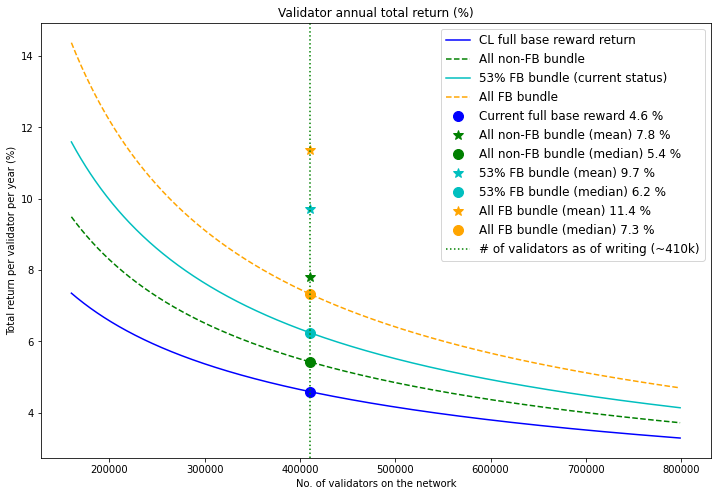

In [5]:
############################
## 1. CL Reward Scenarios ##
############################
####################################################
## Full Rewards: Attest Source, Target and Header ##
####################################################
n_validators = [n for n in range(lower_bound_for_active_staked_eth//32, int(upper_bound_for_active_staked_eth)//32, 1000)]

base_reward = [(base_reward_apr(n, participation_rate=1, scenario='all_check', reward_type='total_reward')) for n in n_validators]
return_fb_mean = [base_reward_apr(n, participation_rate=1, scenario='all_check', reward_type='total_reward') + mev_return(fb_mean_rev, n) for n in n_validators]
return_fb_med = [base_reward_apr(n, participation_rate=1, scenario='all_check', reward_type='total_reward') + mev_return(fb_median_rev, n) for n in n_validators]
return_nfb_mean = [base_reward_apr(n, participation_rate=1, scenario='all_check', reward_type='total_reward') + mev_return(nfb_mean_rev, n) for n in n_validators]
return_nfb_med = [base_reward_apr(n, participation_rate=1, scenario='all_check', reward_type='total_reward') + mev_return(nfb_median_rev, n) for n in n_validators]
return_mean = [base_reward_apr(n, participation_rate=1, scenario='all_check', reward_type='total_reward') + mev_return(mean_rev, n) for n in n_validators]
return_med = [base_reward_apr(n, participation_rate=1, scenario='all_check', reward_type='total_reward') + mev_return(median_rev, n) for n in n_validators]

current_base_reward = base_reward_apr(validators_on_the_network_today, participation_rate=1, scenario='all_check', reward_type='total_reward')
current_return_fb_mean = current_base_reward + mev_return(fb_mean_rev, validators_on_the_network_today)
current_return_nfb_mean = current_base_reward + mev_return(nfb_mean_rev, validators_on_the_network_today)
current_return_mean = current_base_reward + mev_return(mean_rev, validators_on_the_network_today)

current_return_fb_med = current_base_reward + mev_return(fb_median_rev, validators_on_the_network_today)
current_return_nfb_med = current_base_reward + mev_return(nfb_median_rev, validators_on_the_network_today)
current_return_med = current_base_reward + mev_return(median_rev, validators_on_the_network_today)

last_return = base_reward_apr(n=validators_on_the_network_last, participation_rate=1, scenario='all_check', reward_type='total_reward')
last_return_with_mev = last_return + mev_return(avg_mev_reward_per_block_last, validators_on_the_network_last) * (block_selection_frequency_flashbots_last/100)


fig, ax = plt.subplots(figsize=(12, 8))
plt.plot(n_validators, base_reward, color="b", label='CL full base reward return')
plt.plot(n_validators, return_nfb_med, color="g", linestyle="dashed", label='All non-FB bundle')
plt.plot(n_validators, return_med, color="c", label='53% FB bundle (current status)')
plt.plot(n_validators, return_fb_med, color="orange", linestyle="dashed", label='All FB bundle')
plt.plot(validators_on_the_network_today, current_base_reward, marker="o", color="b", markersize=10, linestyle="None", label="Current full base reward {0:.1f} %".format(current_base_reward[3]))
plt.plot(validators_on_the_network_today, current_return_nfb_mean, marker="*", color="g", markersize=10, linestyle="None", label="All non-FB bundle (mean) {0:.1f} %".format(current_return_nfb_mean[3]))
plt.plot(validators_on_the_network_today, current_return_nfb_med, marker="o", color="g", markersize=10, linestyle="None", label="All non-FB bundle (median) {0:.1f} %".format(current_return_nfb_med[3]))
plt.plot(validators_on_the_network_today, current_return_mean, marker="*", color="c", markersize=10, linestyle="None", label="53% FB bundle (mean) {0:.1f} %".format(current_return_mean[3]))
plt.plot(validators_on_the_network_today, current_return_med, marker="o", color="c", markersize=10, linestyle="None", label="53% FB bundle (median) {0:.1f} %".format(current_return_med[3]))
plt.plot(validators_on_the_network_today, current_return_fb_mean, marker="*", color="orange", markersize=10, linestyle="None", label="All FB bundle (mean) {0:.1f} %".format(current_return_fb_mean[3]))
plt.plot(validators_on_the_network_today, current_return_fb_med, marker="o", color="orange", markersize=10, linestyle="None", label="All FB bundle (median) {0:.1f} %".format(current_return_fb_med[3]))
plt.axvline(x=validators_on_the_network_today, linestyle="dotted", color='g', label="# of validators as of writing (~410k)")
# plt.plot(validators_on_the_network_last, last_return_with_mev, color='red', marker="x", markersize=10, linestyle="None", label="Last analysis with FB bundle {0:.1f} %".format(last_return_with_mev[3]))
# plt.plot(validators_on_the_network_last, last_return, color='b', marker="x", markersize=10, linestyle="None", label="Last analysis without FB bundle {0:.1f} %".format(last_return[3]))
# plt.axvline(x=validators_on_the_network_last, linestyle="dotted", label="# of validators from last analysis (~160k)")
ax.set_xlabel('No. of validators on the network')
ax.set_ylabel('Total return per validator per year (%)')
ax.set_title('Validator annual total return (%)')
leg = ax.legend(prop=dict(size=12))

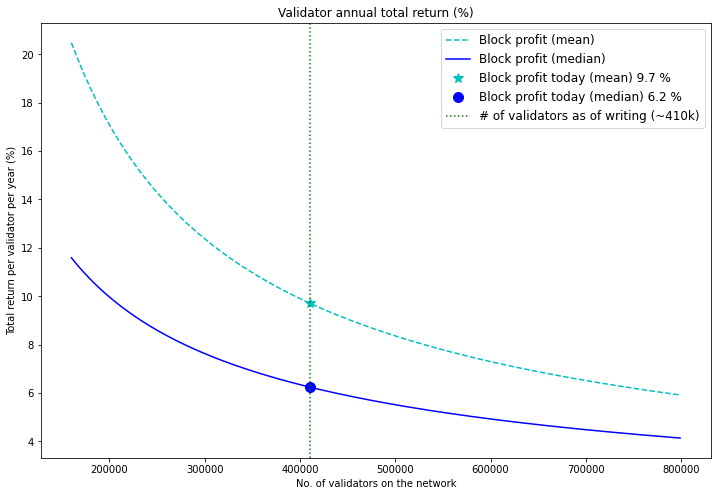

In [6]:
fig, ax = plt.subplots(figsize=(12, 8))
plt.plot(n_validators, return_mean, color="c", linestyle="dashed",label='Block profit (mean)')
plt.plot(n_validators, return_med, color="b", label='Block profit (median)')
plt.plot(validators_on_the_network_today, current_return_mean, marker="*", color="c", markersize=10, linestyle="None", label="Block profit today (mean) {0:.1f} %".format(current_return_mean[3]))
plt.plot(validators_on_the_network_today, current_return_med, marker="o", color="b", markersize=10, linestyle="None", label="Block profit today (median) {0:.1f} %".format(current_return_med[3]))
plt.axvline(x=validators_on_the_network_today, linestyle="dotted", color='g', label="# of validators as of writing (~410k)")
ax.set_xlabel('No. of validators on the network')
ax.set_ylabel('Total return per validator per year (%)')
ax.set_title('Validator annual total return (%)')
leg = ax.legend(prop=dict(size=12))

The chart below compares the scenarios for consensus layer reward:
  - **Full base rewards**: the block reward from consensus layer attestation assuming validator checked all three component - header, source, target and no slashing.
  - **Full base rewards with MEV**: the block reward from consensus layer attestation assuming validator checked all three component, plus MEV approximated using REV from block `12965000` to `15229999`, with 53% of blocks containing FB bundles.
  - **Base rewards (miss header)**: the block reward from consensus layer attestation assuming validator only successfully checked the source and target.
  - **0 Base rewards**: Validators fail to attest the header & target, leading to 0 base reward. When validators fail to attest all three components, there is a penalty i.e. the reward is negative.

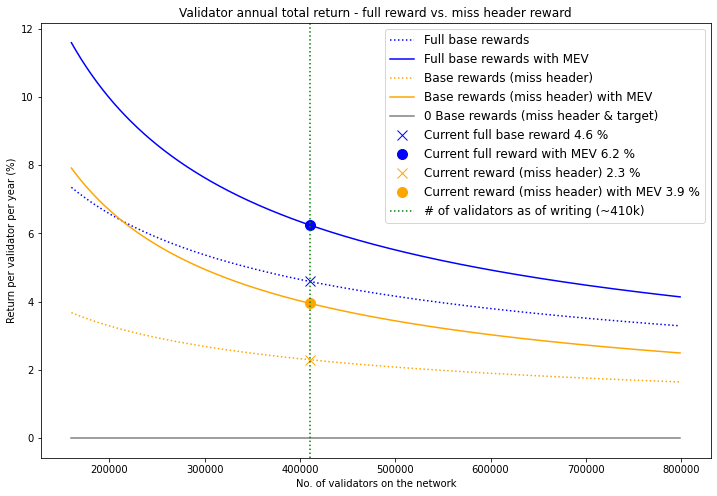

In [7]:
###########################################
## Miss Header: Attest Source and Target ##
###########################################
st_reward = [(base_reward_apr(n, participation_rate=1, scenario='miss_header', reward_type='total_reward')) for n in n_validators]
st_return_fb = [base_reward_apr(n, participation_rate=1, scenario='miss_header', reward_type='total_reward') + mev_return(fb_median_rev, n) for n in n_validators]
st_return_nfb = [base_reward_apr(n, participation_rate=1, scenario='miss_header', reward_type='total_reward') + mev_return(nfb_median_rev, n) for n in n_validators]
st_return = [base_reward_apr(n, participation_rate=1, scenario='miss_header', reward_type='total_reward') + mev_return(median_rev, n) for n in n_validators]

st_current_reward = base_reward_apr(n=validators_on_the_network_today, participation_rate=1, scenario='miss_header', reward_type='total_reward')
st_current_return_fb = st_current_reward + mev_return(fb_median_rev, validators_on_the_network_today)
st_current_return_nfb = st_current_reward + mev_return(nfb_median_rev, validators_on_the_network_today)
st_current_return = st_current_reward + mev_return(median_rev, validators_on_the_network_today)

################################################
## Attest only Source: Miss Header and Target ##
################################################
s_reward = [(base_reward_apr(n, participation_rate=1, scenario='check_source', reward_type='total_reward')) for n in n_validators]
s_return_fb = [(base_reward_apr(n, participation_rate=1, scenario='check_source', reward_type='total_reward') + mev_return(fb_median_rev, n)) for n in n_validators]
s_return_nfb = [(base_reward_apr(n, participation_rate=1, scenario='check_source', reward_type='total_reward') + mev_return(nfb_median_rev, n)) for n in n_validators]
s_return = [(base_reward_apr(n, participation_rate=1, scenario='check_source', reward_type='total_reward') + mev_return(median_rev, n)) for n in n_validators]

s_current_reward = base_reward_apr(validators_on_the_network_today, participation_rate=1, scenario='check_source', reward_type='total_reward')
s_current_return_fb = s_current_reward + mev_return(fb_median_rev, validators_on_the_network_today)
s_current_return_fb = s_current_reward + mev_return(nfb_median_rev, validators_on_the_network_today)
s_current_return = s_current_reward + mev_return(median_rev, validators_on_the_network_today)

##########################################
## Plot for reward scenarios comparison ##
##########################################
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(n_validators, base_reward, label='Full base rewards', color='b', linestyle="dotted")
ax.plot(n_validators, return_med, label='Full base rewards with MEV', color='b')
ax.plot(n_validators, st_reward, label='Base rewards (miss header)', color='orange', linestyle="dotted")
ax.plot(n_validators, st_return, label='Base rewards (miss header) with MEV', color='orange')
ax.plot(n_validators, s_reward, label='0 Base rewards (miss header & target)', color='grey')
# ax.plot(n_validators, s_reward_return, label='Rewards (missing header & target) with MEV', color='c', linestyle="dotted")
plt.plot(validators_on_the_network_today, current_base_reward, marker="x", color='b', linestyle="None", markersize=10,label="Current full base reward {0:.1f} %".format(current_base_reward[3]))
plt.plot(validators_on_the_network_today, current_return_med, marker="o", color='b', linestyle="None", markersize=10,label="Current full reward with MEV {0:.1f} %".format(current_return_med[3]))
plt.plot(validators_on_the_network_today, st_current_reward, marker="x", color='orange', linestyle="None", markersize=10,label="Current reward (miss header) {0:.1f} %".format(st_current_reward[2]))
plt.plot(validators_on_the_network_today, st_current_return, marker="o", color='orange', linestyle="None", markersize=10,label="Current reward (miss header) with MEV {0:.1f} %".format(st_current_return[2]))
plt.axvline(x=validators_on_the_network_today, linestyle="dotted", color='g', label="# of validators as of writing (~410k)")
ax.set_xlabel('No. of validators on the network')
ax.set_ylabel('Return per validator per year (%)')
ax.set_title('Validator annual total return - full reward vs. miss header reward')
leg = ax.legend(prop=dict(size=12))

In [8]:
#@title Reward return % under different attestation scenarios { run: "auto", vertical-output: true }
# setup an array of validators
####################################
## Tabulate returns for scenarios ##
####################################
# setup an array of validators
n_validators_short = [n for n in range(100000, 850000, 50000)]

reward_data = pd.DataFrame({
    '# of validators': n_validators_short,
    'full reward (%)': pd.DataFrame([base_reward_apr(n, participation_rate=1, scenario='all_check', reward_type='total_reward') for n in n_validators_short])[3],
    'full reward with mev (%)':pd.DataFrame([(base_reward_apr(n, participation_rate=1, scenario='all_check', reward_type='total_reward') 
                                              + mev_return(median_rev, n)) for n in n_validators_short])[3],
    'reward (miss header) (%)': pd.DataFrame([(base_reward_apr(n, participation_rate=1, scenario='miss_header', reward_type='total_reward')) for n in n_validators_short])[2],
    'reward (miss header) with mev (%)': pd.DataFrame([(base_reward_apr(n, participation_rate=1, scenario='miss_header', reward_type='total_reward') 
                                                        + mev_return(median_rev, n)) for n in n_validators_short])[2],

})

pd.options.display.float_format = '{:,.2f}'.format
reward_data.set_index('# of validators')




,full reward (%),full reward with mev (%),reward (miss header) (%),reward (miss header) with mev (%)
# of validators,,,,
100000,9.30,16.08,4.65,11.43
150000,7.59,12.11,3.80,8.32
200000,6.57,9.97,3.29,6.68
250000,5.88,8.59,2.94,5.65
300000,5.37,7.63,2.68,4.95
350000,4.97,6.91,2.48,4.42
400000,4.65,6.34,2.32,4.02
450000,4.38,5.89,2.19,3.70
500000,4.16,5.51,2.08,3.44


## 2. Number of Blocks Proposed Scenarios

In this scenario, we simulate the expected number of blocks proposed per year per validator. The following scenarios are compared in the charts:
- Compare probability density function (PDF) between the number of validators now 410k and before from the last analysis 100k
-  Compare the 1%, 50% and 99% points of the cumulative density function (CDF) between 410k validators and 100k validators

Binomial distributions can be symmetrical or skewed. When p = 0.5, the binomial distribution will be symmetrical, regardless of how large or small the value of n. But when p < 0.5, the distribution is right skewed, vice versa if p > 0.5.

Due to the increasing number of validators over time, the probability of being a block proposer decreases over time. This is why the distribution becomes more unsymmetrical and more skewed to the right; and the number of expected block to propose per validator per year also decreases.

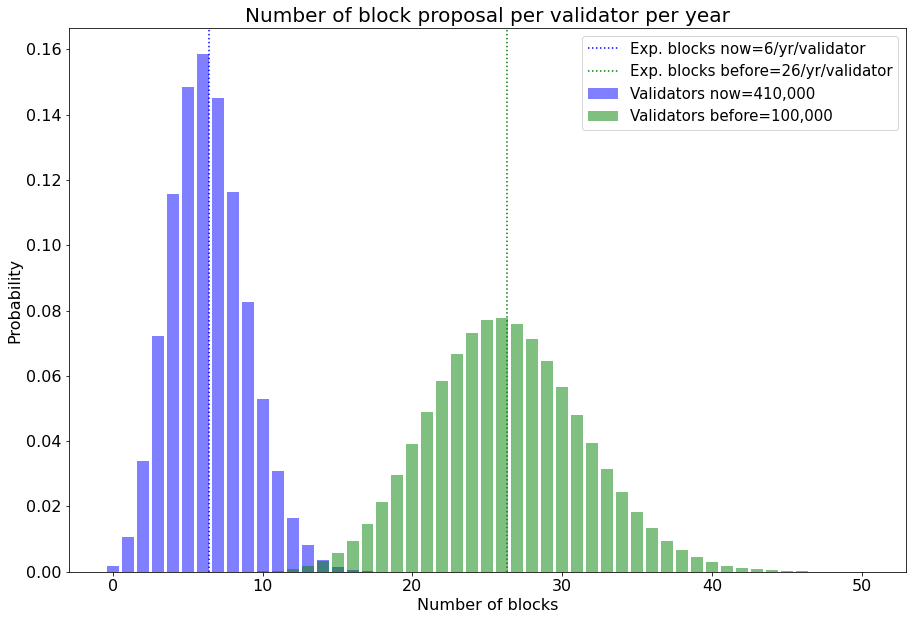

In [9]:
#@title Compare distribution with different number of validators { run: "auto", vertical-output: true }

###########################################
## 2. Number of Block Proposed Scenarios ##
###########################################
## Compare PDF of last analysis vs. now
x = range(0,51,1)
y = binom.pmf(x, SECONDS_PER_YEAR/SECONDS_PER_SLOT, 1/validators_on_the_network_today)
y_last = binom.pmf(x, SECONDS_PER_YEAR/SECONDS_PER_SLOT, 1/100000)

plt.figure(figsize=(15,10))
plt.bar(x, y, color = 'b', label='Validators now=410,000', alpha=0.5)
plt.bar(x, y_last, color = 'g',label='Validators before=100,000', alpha=0.5)
plt.axvline(x=number_of_blocks_per_validator_per_year, linestyle="dotted", color='b', label="Exp. blocks now={0:.0f}/yr/validator".format(number_of_blocks_per_validator_per_year))
plt.axvline(x=(SECONDS_PER_YEAR/SECONDS_PER_SLOT)/100000, linestyle="dotted", color='g', label="Exp. blocks before={0:.0f}/yr/validator".format((SECONDS_PER_YEAR/SECONDS_PER_SLOT)/100000))
plt.xlabel("Number of blocks",fontsize=16)
plt.ylabel("Probability", fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title("Number of block proposal per validator per year", fontsize=20)
plt.legend(prop={'size': 15})


(array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

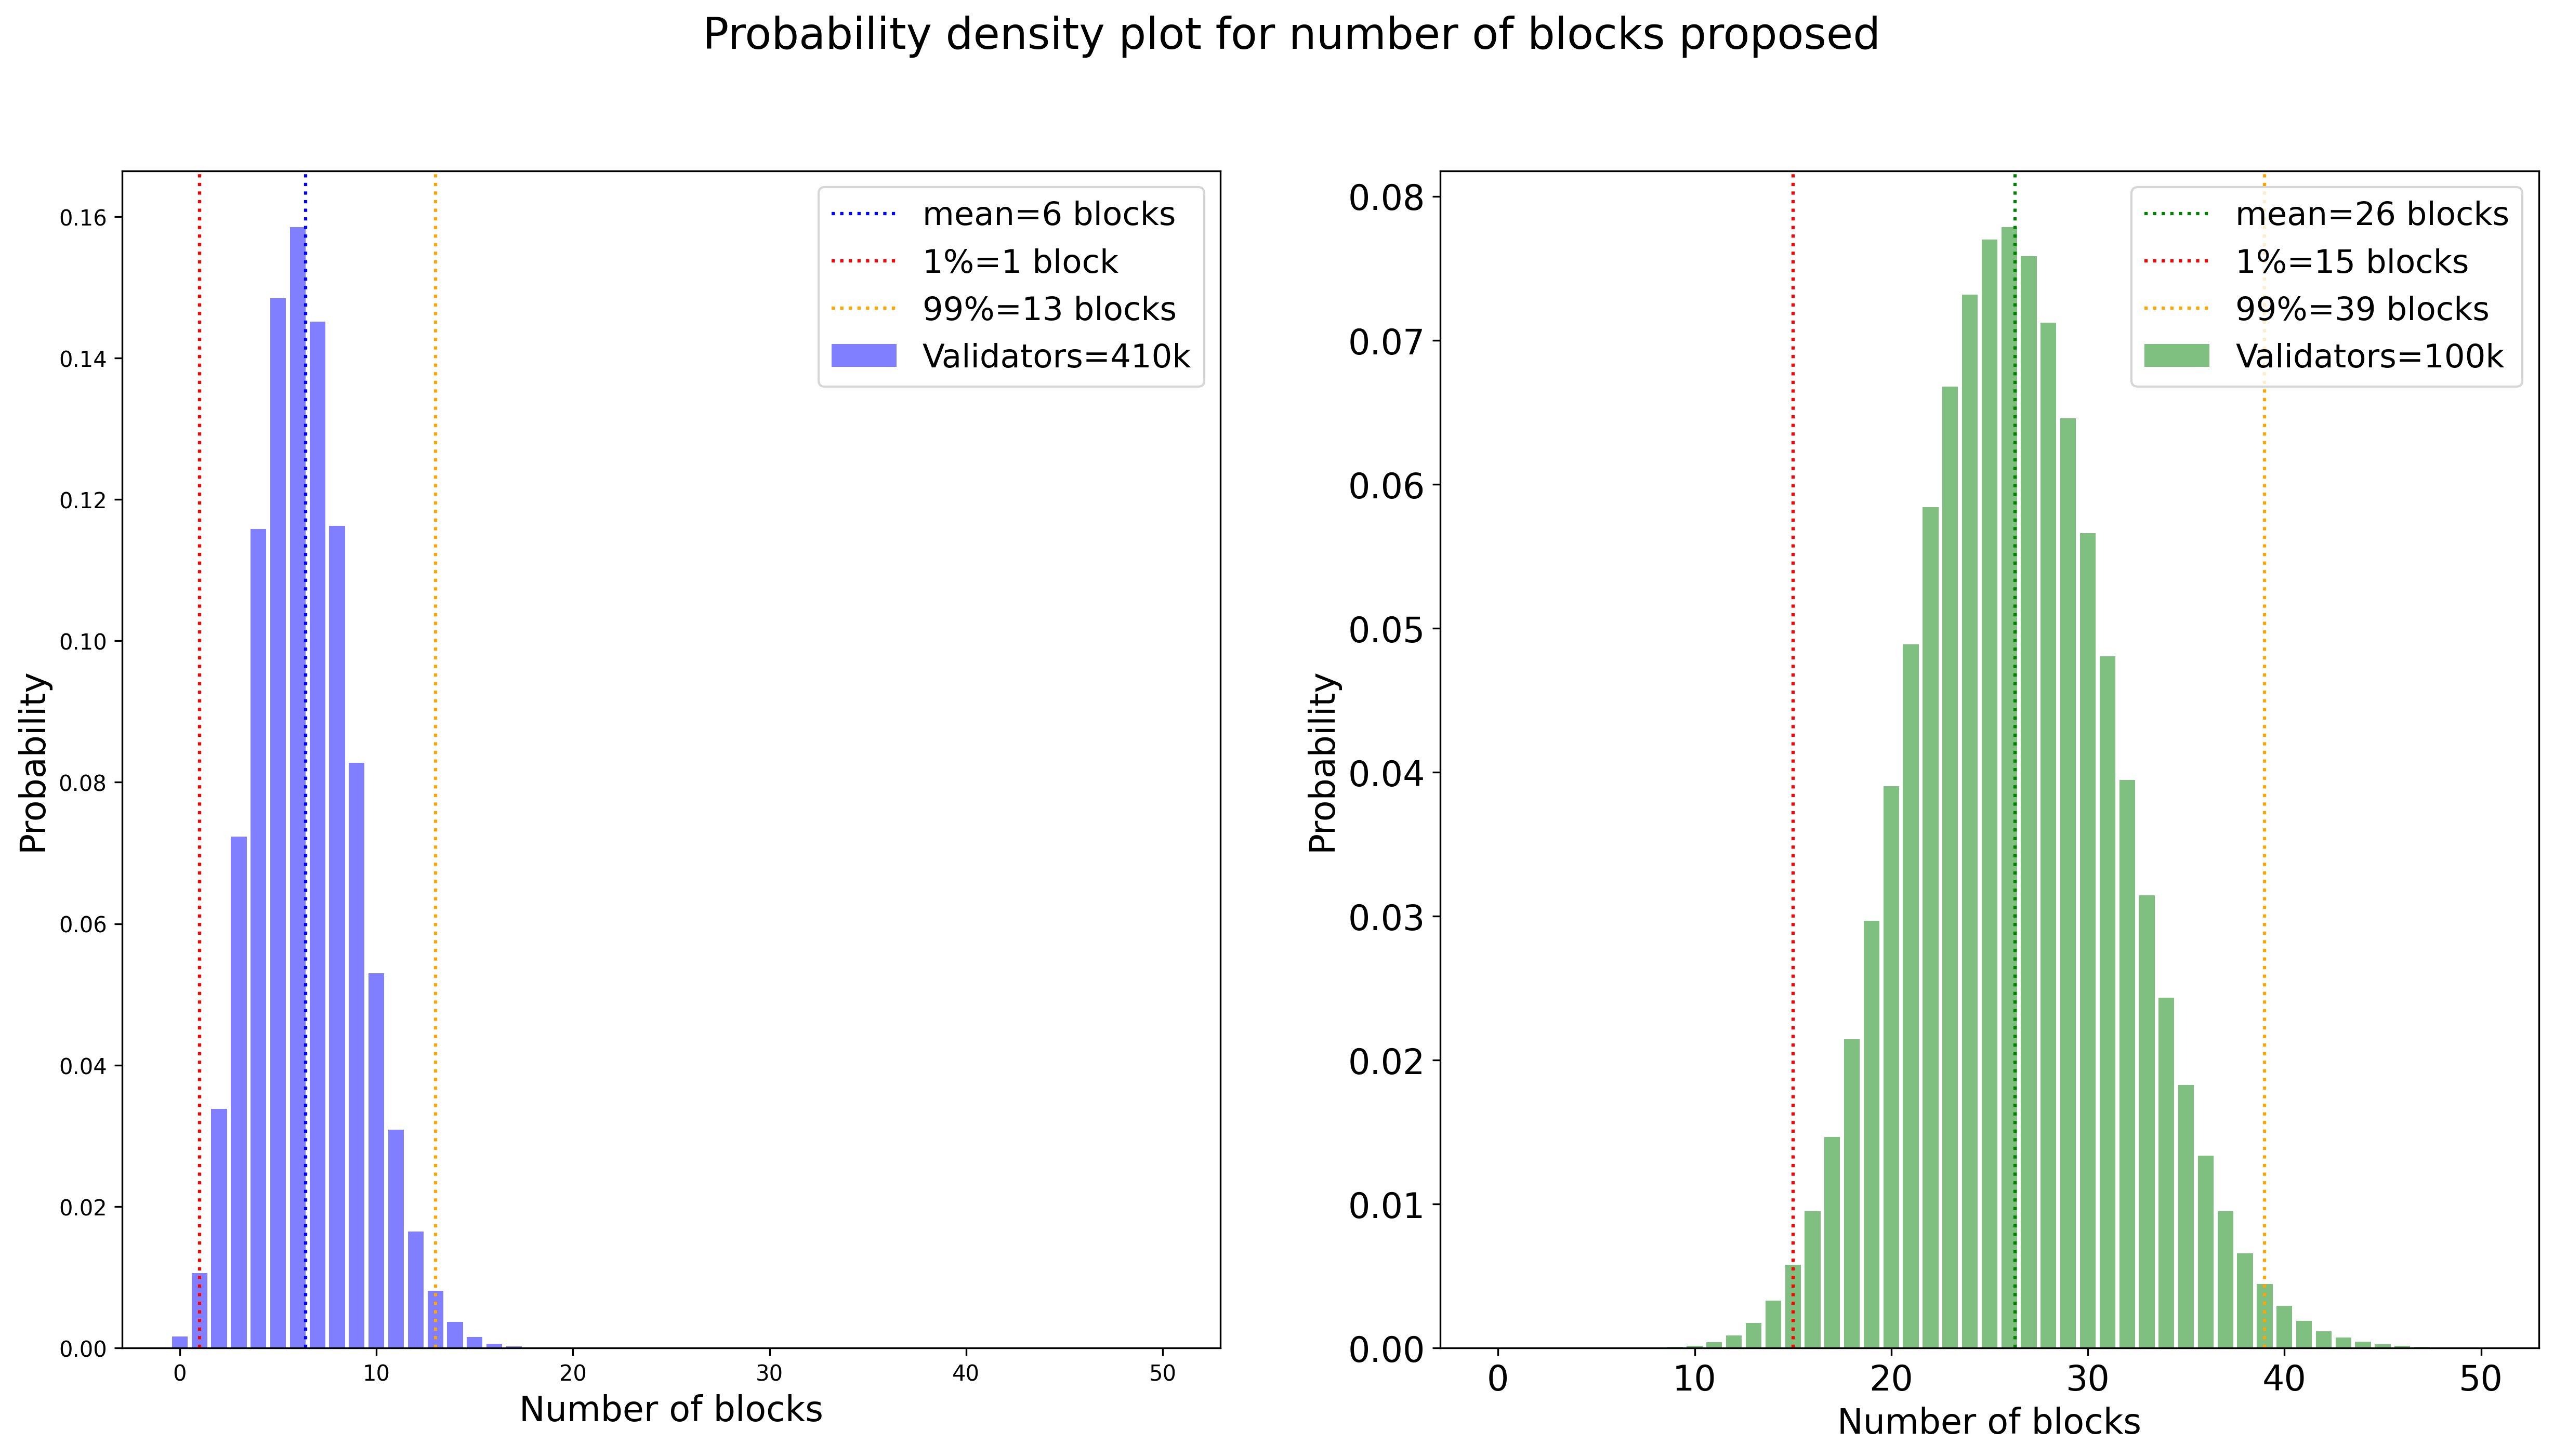

In [10]:
#@title Compare the best, worst and average points with different number of validators { run: "auto", vertical-output: true }
## Compare 1%, 50%, 99% CDF on PDF
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 10), dpi=300)
fig.suptitle('Probability density plot for number of blocks proposed', size=20)
ax1.bar(x, y, color = 'b', label='Validators=410k', alpha=0.5)
ax1.axvline(x=number_of_blocks_per_validator_per_year, linestyle="dotted", color='b', label="mean={0:.0f} blocks".format(number_of_blocks_per_validator_per_year))
ax1.axvline(x=binom.ppf(0.01, SECONDS_PER_YEAR/SECONDS_PER_SLOT, 1/validators_on_the_network_today), linestyle="dotted", color='red', label="1%={0:.0f} block".format(binom.ppf(0.01, SECONDS_PER_YEAR/SECONDS_PER_SLOT, 1/validators_on_the_network_today)))
ax1.axvline(x=binom.ppf(0.99, SECONDS_PER_YEAR/SECONDS_PER_SLOT, 1/validators_on_the_network_today), linestyle="dotted", color='orange', label="99%={0:.0f} blocks".format(binom.ppf(0.99, SECONDS_PER_YEAR/SECONDS_PER_SLOT, 1/validators_on_the_network_today)))
ax1.legend(prop={'size': 15})
ax1.set_xlabel("Number of blocks",fontsize=16)
ax1.set_ylabel("Probability",fontsize=16)
ax2.bar(x, y_last, color = 'g',label='Validators=100k', alpha=0.5)
ax2.axvline(x=(SECONDS_PER_YEAR/SECONDS_PER_SLOT)/100000, linestyle="dotted", color='g', label="mean={0:.0f} blocks".format((SECONDS_PER_YEAR/SECONDS_PER_SLOT)/100000))
ax2.axvline(x=binom.ppf(0.01, SECONDS_PER_YEAR/SECONDS_PER_SLOT, 1/100000), linestyle="dotted", color='red', label="1%={0:.0f} blocks".format(binom.ppf(0.01, SECONDS_PER_YEAR/SECONDS_PER_SLOT, 1/100000)))
ax2.axvline(x=binom.ppf(0.99, SECONDS_PER_YEAR/SECONDS_PER_SLOT, 1/100000), linestyle="dotted", color='orange', label="99%={0:.0f} blocks".format(binom.ppf(0.99, SECONDS_PER_YEAR/SECONDS_PER_SLOT, 1/100000)))
ax2.legend(prop={'size': 15})
ax2.set_xlabel("Number of blocks",fontsize=16)
ax2.set_ylabel("Probability",fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

/Users/elainehu/opt/anaconda3/envs/spyder/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/elainehu/opt/anaconda3/envs/spyder/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/elainehu/opt/anaconda3/envs/spyder/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to

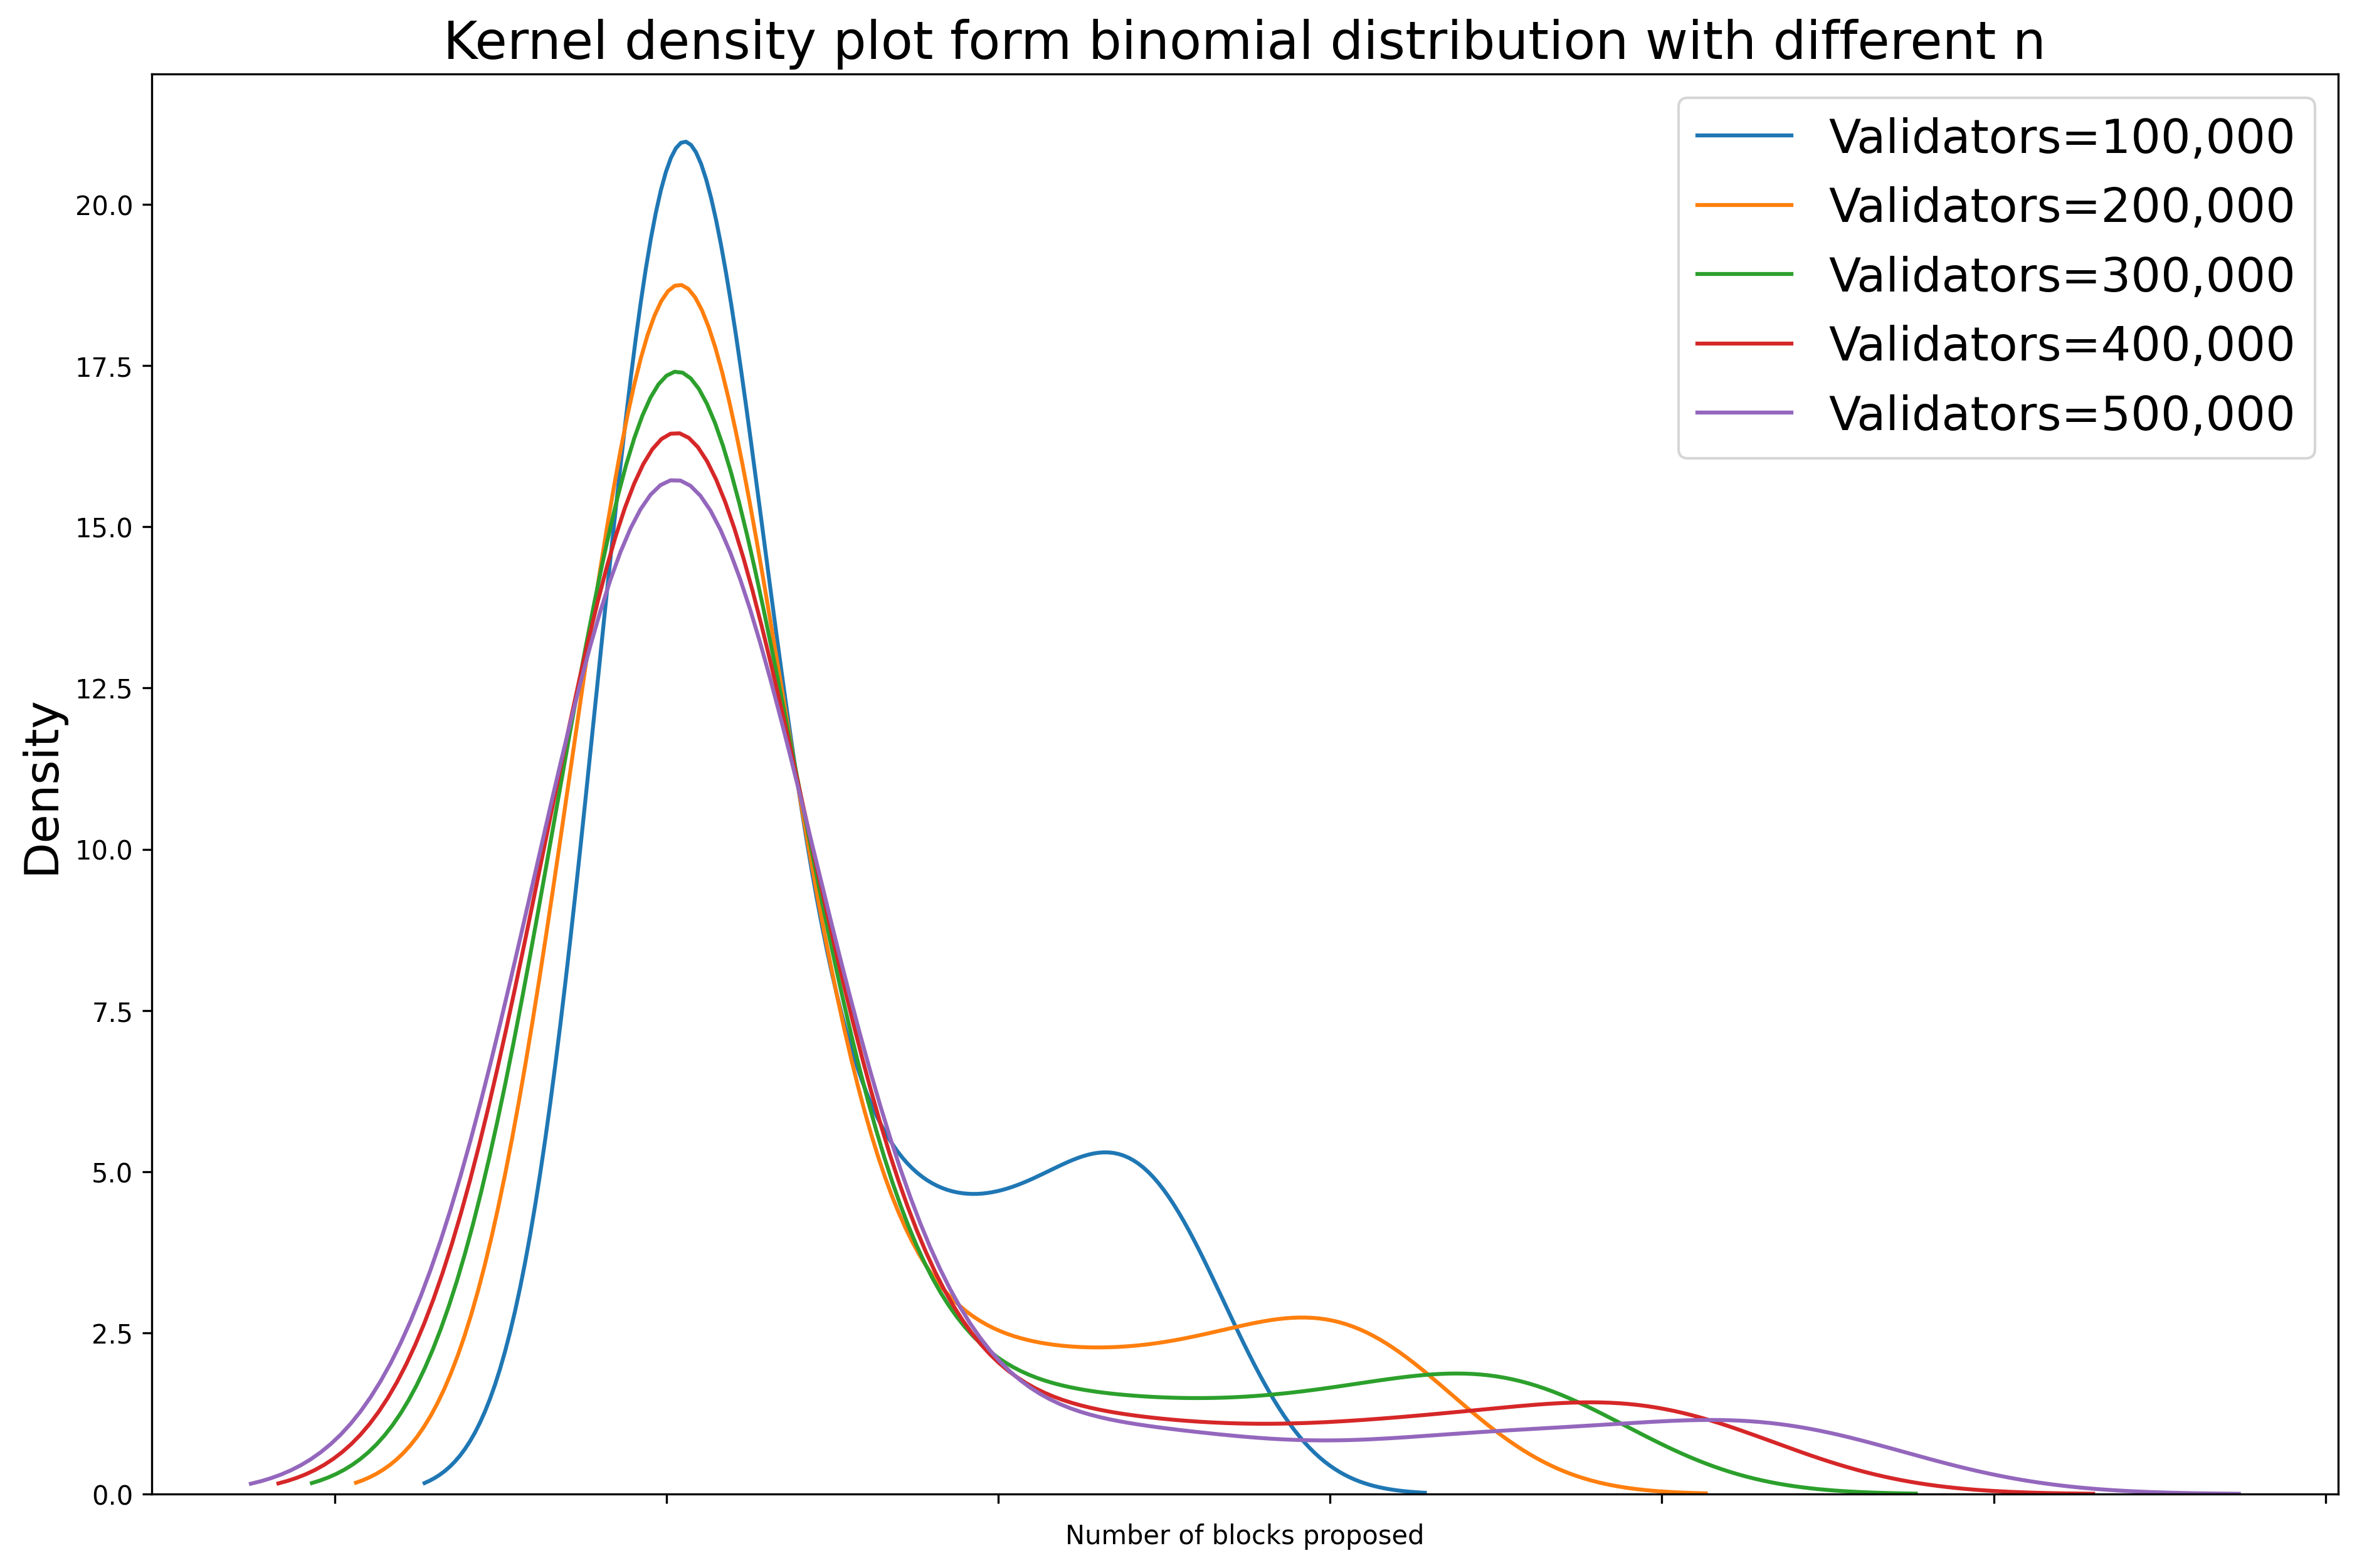

In [11]:
#@title Compare distribution fat tail with different number of validators { run: "auto", vertical-output: true }

## Compare PDF with different # of validators
fig, ax = plt.subplots(1, 1, figsize = (15, 10), dpi=300)
sns.distplot(y_last, rug=False, hist=False, label='Validators=100,000')
sns.distplot(binom.pmf(x, SECONDS_PER_YEAR/SECONDS_PER_SLOT, 1/200000), rug=False, hist=False, label='Validators=200,000')
sns.distplot(binom.pmf(x, SECONDS_PER_YEAR/SECONDS_PER_SLOT, 1/300000), rug=False, hist=False, label='Validators=300,000')
sns.distplot(binom.pmf(x, SECONDS_PER_YEAR/SECONDS_PER_SLOT, 1/400000), rug=False, hist=False, label='Validators=400,000')
sns.distplot(binom.pmf(x, SECONDS_PER_YEAR/SECONDS_PER_SLOT, 1/500000), rug=False, hist=False, label='Validators=500,000')
ax.set_title('Kernel density plot form binomial distribution with different n', size=20) 
ax.set(xticklabels=[])
ax.yaxis.label.set_size(18)
ax.set_xlabel('Number of blocks proposed')
ax.legend(prop={'size': 18})

Given the number of validators, a binomial distribution can be used to generate the luckiest and unluckiest 1% of blocks that a validator expects to propose per year. At the current level of 400k validators, the unluckiest 1% validators only get to propose 1 block a year, whereas the luckiest will propose 13 blocks a year.

In [12]:
#@title Expected number of blocks proposed per year per validator { run: "auto", vertical-output: true }
## Tabulate table of CDF 1%, 99%, 50%
block_proposed = pd.DataFrame({
    '# of validators': n_validators_short,
    'bottom 1%': [(binom.ppf(0.01,SECONDS_PER_YEAR/SECONDS_PER_SLOT, 1/n)) for n in n_validators_short],
    'median': [(binom.ppf(0.5,SECONDS_PER_YEAR/SECONDS_PER_SLOT, 1/n)) for n in n_validators_short],
    'top 1%': [(binom.ppf(0.99,SECONDS_PER_YEAR/SECONDS_PER_SLOT, 1/n)) for n in n_validators_short],

})
block_proposed
pd.options.display.float_format = '{:,.0f}'.format
block_proposed.set_index('# of validators')


,bottom 1%,median,top 1%
# of validators,,,
100000,15,26,39
150000,9,17,28
200000,6,13,22
250000,4,10,19
300000,3,9,16
350000,2,7,15
400000,1,6,13
450000,1,6,12
500000,1,5,11


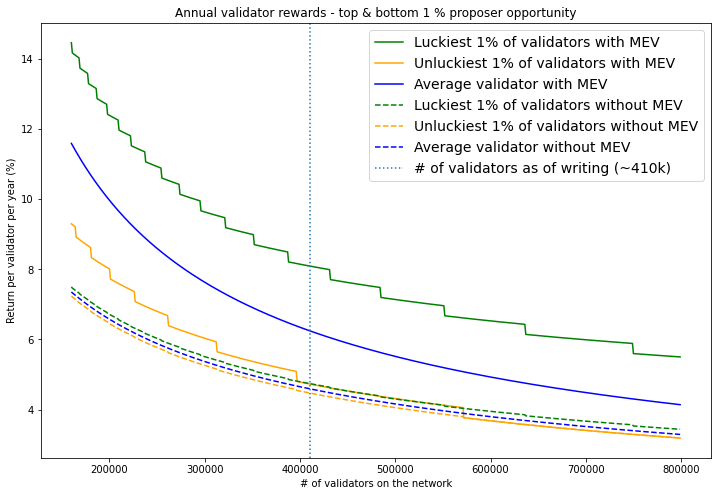

In [13]:
#@title Expected number of blocks proposed scenaio
## Incorporate block proposed scenarios into reward return
n_validators = [n for n in range(lower_bound_for_active_staked_eth//32,int(upper_bound_for_active_staked_eth)//32,1000)] # get no of validators for the range 0.5M to 10M staked ETH, 3200 at a time
full_reward = [(4 * annualised_base_reward(n)) for n in n_validators]
attestation_reward = [0.75 * f for f in full_reward]
inclusion_reward = [0.25 * f for f in full_reward]

# calculate lower and upper quartiles for block proposal opportunities
l_bpo = [int(binom.ppf(0.01,SECONDS_PER_YEAR/SECONDS_PER_SLOT, 1/n)) for n in n_validators]
mean_bpo = [float(binom.mean(SECONDS_PER_YEAR/SECONDS_PER_SLOT, 1/n)) for n in n_validators]
u_bpo = [int(binom.ppf(0.99,SECONDS_PER_YEAR/SECONDS_PER_SLOT, 1/n)) for n in n_validators]

full_reward_with_mev = [(4 * annualised_base_reward(n)+ (median_rev * average_blocks_proposed_per_year(n))) for n in n_validators] 

# calculate lower and upper quartiles for ideal reward, based on block proposal opportunties
l_reward, u_reward = [], [] # With MEV
for i in range(len(full_reward)):
    r_att = attestation_reward[i]
    r_inc = inclusion_reward[i]
    l_reward.append(r_att + r_inc * ((7/8) + (1/8) * l_bpo[i] / mean_bpo[i]))
    l_reward[i] = l_reward[i] + (l_bpo[i] * median_rev)
    u_reward.append(r_att + r_inc * ((7/8) + (1/8) * u_bpo[i] / mean_bpo[i]))
    u_reward[i] = u_reward[i] + (u_bpo[i] * median_rev)

l_reward_without_mev, u_reward_without_mev = [], []
for i in range(len(full_reward)):
    r_att = attestation_reward[i]
    r_inc = inclusion_reward[i]
    l_reward_without_mev.append(r_att + r_inc * ((7/8) + (1/8) * l_bpo[i] / mean_bpo[i]))
    u_reward_without_mev.append(r_att + r_inc * ((7/8) + (1/8) * u_bpo[i] / mean_bpo[i]))


fig, ax = plt.subplots(figsize=(12, 8))
ax.plot([n for n in n_validators], [100 * r / 32 for r in u_reward] , 'g', label='Luckiest 1% of validators with MEV')
ax.plot([n for n in n_validators], [100 * r / 32 for r in l_reward], 'orange', label='Unluckiest 1% of validators with MEV')
ax.plot([n for n in n_validators], [100 * r / 32 for r in full_reward_with_mev], 'b', label='Average validator with MEV')
ax.plot([n for n in n_validators], [100 * r / 32 for r in u_reward_without_mev] , 'g', linestyle="dashed", label='Luckiest 1% of validators without MEV')
ax.plot([n for n in n_validators], [100 * r / 32 for r in l_reward_without_mev], 'orange', linestyle="dashed",label='Unluckiest 1% of validators without MEV')
ax.plot([n for n in n_validators], [100 * r / 32 for r in full_reward], 'b', linestyle="dashed", label='Average validator without MEV')
ax.set_xlabel('# of validators on the network')
ax.set_ylabel('Return per validator per year (%)')
plt.axvline(x=validators_on_the_network_today, linestyle="dotted", label="# of validators as of writing (~410k)")
ax.set_title('Annual validator rewards - top & bottom 1 % proposer opportunity')
leg = ax.legend(prop={'size': 14})

## 3. REV Scenarios

In stead of using a fixed median REV, in this scenario the simulations are done based on the model predicted REV in each block. The prediction is calibrated on the actual block net profit from block number `12965000` to `15229999`. The 2 ETH static reward from PoW is replaced with the PoS block reward, which is dependent on the number of validators, then added to the predicted REV to get the validator annual return. The following models are used for the REV prediction with confidence intervals at 2.5% and 97.5%
:
  - Random Forest: 500 trees with maximum 4 levels of tree depth
  - ARIMA (2,0,1): Log-transformed variables with 2 lag terms, 0 differencing and 1 moving average  prediction





### 3.1 Random Forest Predicted REV
Due to the extremely large REV in some blocks, the outliers are smoothed out by taking the median REV of all blocks in an hour. The predictions are therefore at an hourly frequency. The plot of REV prediction against the # of validators is aggregated by taking the median of the predictions too since the # of validators are updated less than an hour i.e. there're multiple MEV predictions given the same # of validators.

Although the predictions manage to capture the spikes in some periods, during the recent period they are very flat. This is due to the nature of random forest averaging across all trees' predictions. The past high return periods have more weights in the calibration so the recent low return period does not get a responsive prediction.

In [14]:
#@title Load RF predicted REV
######################
## 3. REV Secnarios ##
######################
#####################################
## 3.1 Random Forest predicted REV ##
#####################################
## Import REV predictions from Random Forest
rev_rf_predict = pd.read_csv('Data/rev_randomforest.csv')
rev_rf_predict['datetime_d'] = rev_rf_predict['datetime_h'].apply(lambda x: left(x, 10))

## Import validator numbers from https://www.beaconcha.in/charts/validators
val_num =  pd.read_csv("Data/validator_numbers.csv")
val_num['timestamp'] = np.round(val_num['timestamp']/1000)
val_num['datetime_d'] = val_num['timestamp'].apply(format_date_d)

## Merge number of validators to REV prediction
rev_rf_predict = rev_rf_predict.merge(val_num[['datetime_d', 'validator_number']], how='left', on='datetime_d')
rev_rf_predict['annual_full_reward'] = [(4 * annualised_base_reward(n)) for n in rev_rf_predict['validator_number'].tolist()] 
rev_rf_predict['annual_total_reward_with_mev_actual'] = rev_rf_predict['annual_full_reward'] + rev_rf_predict['median_block_net_profit'] * (SECONDS_PER_YEAR / (SECONDS_PER_SLOT * rev_rf_predict['validator_number'])) 
rev_rf_predict['annual_total_reward_with_mev'] = rev_rf_predict['annual_full_reward'] + rev_rf_predict['predict'] * (SECONDS_PER_YEAR / (SECONDS_PER_SLOT * rev_rf_predict['validator_number']))
rev_rf_predict['annual_total_reward_with_mev_lb'] = rev_rf_predict['annual_full_reward'] + rev_rf_predict['predict_lb'] * (SECONDS_PER_YEAR / (SECONDS_PER_SLOT * rev_rf_predict['validator_number']))
rev_rf_predict['annual_total_reward_with_mev_ub'] = rev_rf_predict['annual_full_reward'] + rev_rf_predict['predict_ub'] * (SECONDS_PER_YEAR / (SECONDS_PER_SLOT * rev_rf_predict['validator_number']))
rev_rf_predict['annual_predict_mev'] = rev_rf_predict['predict'] * (SECONDS_PER_YEAR / (SECONDS_PER_SLOT * rev_rf_predict['validator_number']))
rev_rf_predict['annual_predict_mev_lb'] = rev_rf_predict['predict_lb'] * (SECONDS_PER_YEAR / (SECONDS_PER_SLOT * rev_rf_predict['validator_number']))
rev_rf_predict['annual_predict_mev_ub'] = rev_rf_predict['predict_ub'] * (SECONDS_PER_YEAR / (SECONDS_PER_SLOT * rev_rf_predict['validator_number']))


## Plot realised total reward by # of validators
agg_rev_data = pd.DataFrame(rev_rf_predict.groupby("validator_number")["annual_full_reward"].median()).reset_index()
reward_actual = pd.DataFrame(rev_rf_predict.groupby("validator_number")["annual_total_reward_with_mev_actual"].median()).reset_index()
reward_pred = pd.DataFrame(rev_rf_predict.groupby("validator_number")["annual_total_reward_with_mev"].median()).reset_index()
reward_pred_lb = pd.DataFrame(rev_rf_predict.groupby("validator_number")["annual_total_reward_with_mev_lb"].median()).reset_index()
reward_pred_ub = pd.DataFrame(rev_rf_predict.groupby("validator_number")["annual_total_reward_with_mev_ub"].median()).reset_index()

agg_rev_data = agg_rev_data.merge(reward_actual, on = "validator_number", how = 'left')
agg_rev_data = agg_rev_data.merge(reward_pred, on = "validator_number", how = 'left')
agg_rev_data = agg_rev_data.merge(reward_pred_lb, on = "validator_number", how = 'left')
agg_rev_data = agg_rev_data.merge(reward_pred_ub, on = "validator_number", how = 'left')


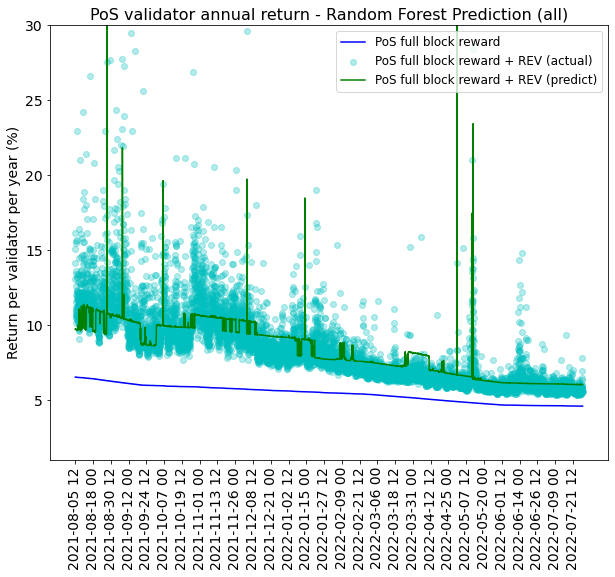

In [28]:
#@title Predicted REV per hourly timestamp
plt.figure(figsize=(10,8))
plt.plot(rev_rf_predict['datetime_h'], 100*rev_rf_predict['annual_full_reward']/32, color = 'b', label='PoS full block reward')
plt.scatter(rev_rf_predict['datetime_h'], 100*rev_rf_predict['annual_total_reward_with_mev_actual']/32, color = 'c',label='PoS full block reward + REV (actual)', alpha=0.3)
plt.plot(rev_rf_predict['datetime_h'], 100*rev_rf_predict['annual_total_reward_with_mev']/32, color = 'g',label='PoS full block reward + REV (predict)')
plt.ylabel("Return per validator per year (%)", fontsize=14)
plt.xticks(np.arange(0, len(rev_rf_predict), 300), fontsize=14)
plt.yticks(fontsize=14)
plt.xticks(rotation = 90)
plt.ylim(1, 30)
plt.title("PoS validator annual return - Random Forest Prediction (all)", fontsize=16)
plt.legend(prop={'size': 12}, loc='upper right')


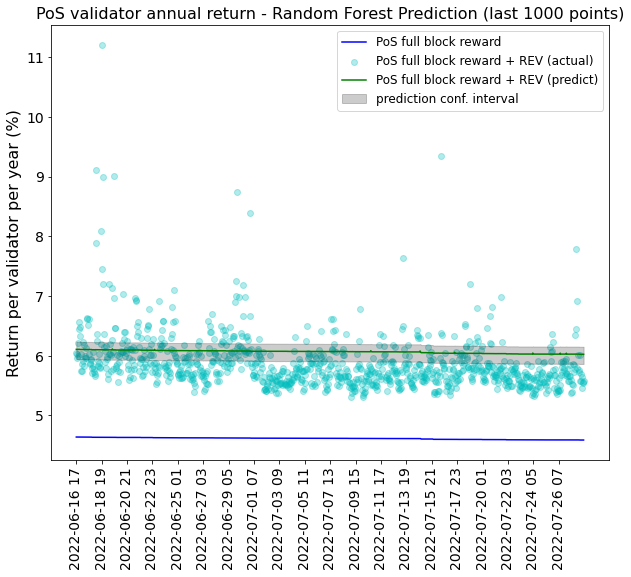

In [29]:
#@title Predicted REV per hourly timestamp - last 1000 hours
show_n = 1000
plt.figure(figsize=(10,8))
plt.plot(rev_rf_predict['datetime_h'].tail(show_n), 100*rev_rf_predict['annual_full_reward'].tail(show_n)/32, color = 'b', label='PoS full block reward')
plt.scatter(rev_rf_predict['datetime_h'].tail(show_n), 100*rev_rf_predict['annual_total_reward_with_mev_actual'].tail(show_n)/32, color = 'c',label='PoS full block reward + REV (actual)', alpha=0.3)
plt.plot(rev_rf_predict['datetime_h'].tail(show_n), 100*rev_rf_predict['annual_total_reward_with_mev'].tail(show_n)/32, color = 'g',label='PoS full block reward + REV (predict)')
plt.fill_between(rev_rf_predict['datetime_h'].tail(show_n), 
                  100*rev_rf_predict['annual_total_reward_with_mev_lb'].tail(show_n)/32, 
                  100*rev_rf_predict['annual_total_reward_with_mev_ub'].tail(show_n)/32, 
                  color='k', alpha=0.2, label='prediction conf. interval')
plt.ylabel("Return per validator per year (%)", fontsize=16)
plt.xticks(np.arange(0, show_n, 50), fontsize=14)
plt.yticks(fontsize=14)
# plt.ylim(1.45, 1.85)
plt.xticks(rotation = 90)
plt.title("PoS validator annual return - Random Forest Prediction (last 1000 points)", fontsize=16)
plt.legend(prop={'size': 12}, loc='upper right')


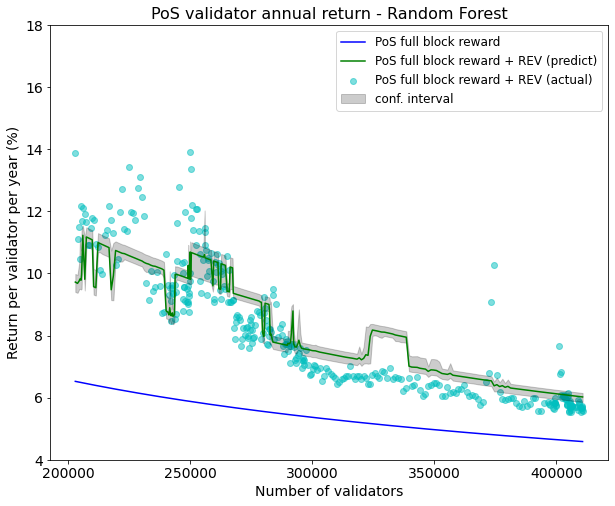

In [34]:
#@title Predicted REV per # of validators
plt.figure(figsize=(10,8))
plt.plot(agg_rev_data['validator_number'], 100*agg_rev_data['annual_full_reward']/32, color = 'b', label='PoS full block reward')
plt.plot(agg_rev_data['validator_number'], 100*agg_rev_data['annual_total_reward_with_mev']/32, color = 'g',label='PoS full block reward + REV (predict)')
plt.scatter(agg_rev_data['validator_number'], 100*agg_rev_data['annual_total_reward_with_mev_actual']/32, color = 'c',label='PoS full block reward + REV (actual)', alpha=0.5)
plt.fill_between(agg_rev_data['validator_number'], 
                  100*agg_rev_data['annual_total_reward_with_mev_lb']/32, 
                  100*agg_rev_data['annual_total_reward_with_mev_ub']/32, 
                  color='k', alpha=0.2, label='conf. interval')
plt.xlabel("Number of validators",fontsize=14)
plt.ylabel("Return per validator per year (%)", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylim(4,18)
plt.title("PoS validator annual return - Random Forest", fontsize=16)
plt.legend(prop={'size': 12}, loc='upper right')

The following charts combine the proposer scenario with the predicted REV scenario. The luckiest 1% scenario represents the luckiest 1% proposers who get to propose 13 blocks per year given 400k validators, and generate the upper bound of 97.5 percentile REV. The unluckiest 1% scenario is the unluckiest 1% proposers who only propose 1 block per year given 400k validators, and generate the lower bound 2.5 percentile REV.

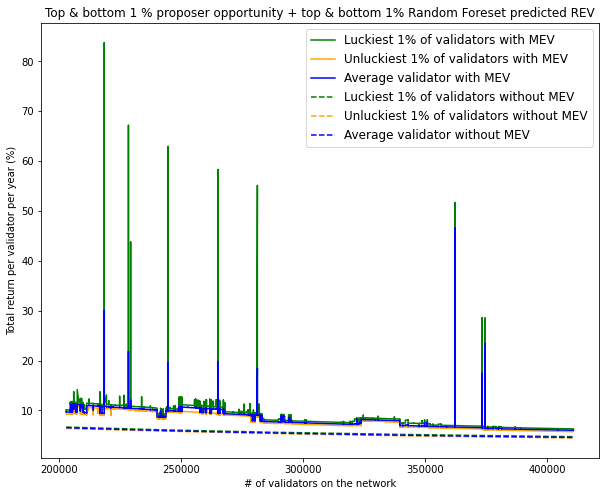

In [18]:
#############################################################
## Incorporate block proposed scenarios into reward return ##
#############################################################
rev_rf_predict['attestation_reward'] = 0.75 * rev_rf_predict["annual_full_reward"]
rev_rf_predict['inclusion_reward'] = 0.25 * rev_rf_predict["annual_full_reward"]
rev_rf_predict['l_bpo'] = [(binom.ppf(0.01,SECONDS_PER_YEAR/SECONDS_PER_SLOT, 1/n)) for n in rev_rf_predict['validator_number'].tolist()]
rev_rf_predict['mean_bpo'] = [float(binom.mean(SECONDS_PER_YEAR/SECONDS_PER_SLOT, 1/n)) for n in rev_rf_predict['validator_number'].tolist()]
rev_rf_predict['u_bpo'] = [(binom.ppf(0.99,SECONDS_PER_YEAR/SECONDS_PER_SLOT, 1/n)) for n in rev_rf_predict['validator_number'].tolist()]


l_reward, u_reward = [], [] # With MEV
for i in range(len(rev_rf_predict)):
    r_att = rev_rf_predict['attestation_reward'][i]
    r_inc = rev_rf_predict['inclusion_reward'][i]
    l_reward.append(r_att + r_inc * ((7/8) + (1/8) * rev_rf_predict['l_bpo'][i] / rev_rf_predict['mean_bpo'][i]))
    l_reward[i] = l_reward[i] + (rev_rf_predict['mean_bpo'][i] * rev_rf_predict['predict_lb'][i])
    u_reward.append(r_att + r_inc * ((7/8) + (1/8) * rev_rf_predict['u_bpo'][i] / rev_rf_predict['mean_bpo'][i]))
    u_reward[i] = u_reward[i] + (rev_rf_predict['mean_bpo'][i] * rev_rf_predict['predict_ub'][i])

l_reward_without_mev, u_reward_without_mev = [], []
for i in range(len(rev_rf_predict)):
    r_att = rev_rf_predict['attestation_reward'][i]
    r_inc = rev_rf_predict['inclusion_reward'][i]
    l_reward_without_mev.append(r_att + r_inc * ((7/8) + (1/8) * rev_rf_predict['l_bpo'][i] / rev_rf_predict['mean_bpo'][i]))
    u_reward_without_mev.append(r_att + r_inc * ((7/8) + (1/8) * rev_rf_predict['u_bpo'][i] / rev_rf_predict['mean_bpo'][i]))

## Plot total reward by # of validators
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot([n for n in rev_rf_predict['validator_number'].tolist()], [100 * r / 32 for r in u_reward] , 'g', label='Luckiest 1% of validators with MEV')
ax.plot([n for n in rev_rf_predict['validator_number'].tolist()], [100 * r / 32 for r in l_reward], 'orange', label='Unluckiest 1% of validators with MEV')
ax.plot([n for n in rev_rf_predict['validator_number'].tolist()], 100*rev_rf_predict['annual_total_reward_with_mev']/32, 'b', label='Average validator with MEV')
ax.plot([n for n in rev_rf_predict['validator_number'].tolist()], [100 * r / 32 for r in u_reward_without_mev] , 'g', linestyle="dashed", label='Luckiest 1% of validators without MEV')
ax.plot([n for n in rev_rf_predict['validator_number'].tolist()], [100 * r / 32 for r in l_reward_without_mev], 'orange', linestyle="dashed",label='Unluckiest 1% of validators without MEV')
ax.plot([n for n in rev_rf_predict['validator_number'].tolist()], 100*rev_rf_predict['annual_full_reward']/32, 'b', linestyle="dashed", label='Average validator without MEV')
ax.set_xlabel('# of validators on the network')
ax.set_ylabel('Total return per validator per year (%)')
ax.set_title('Top & bottom 1 % proposer opportunity + top & bottom 1% Random Foreset predicted REV')
leg = ax.legend(prop={'size': 12})

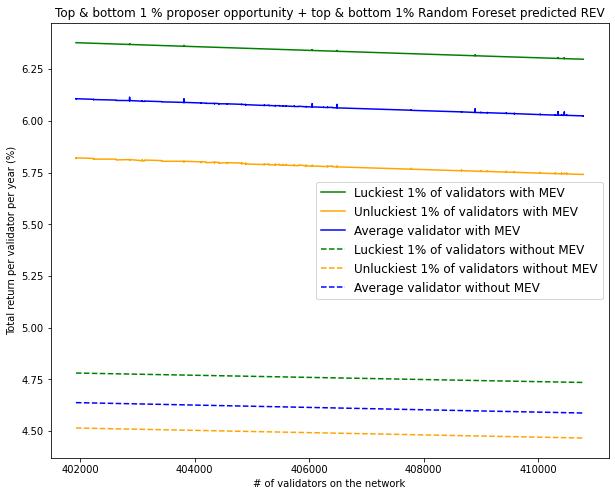

In [19]:
#@title Block proposal opportunties & predicted REV with 2.5%, 97.5% CI - last 1000 data points
show_n = 1000
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot([n for n in rev_rf_predict['validator_number'].tail(show_n).tolist()], [100 * r / 32 for r in u_reward[-show_n:]] , 'g', label='Luckiest 1% of validators with MEV')
ax.plot([n for n in rev_rf_predict['validator_number'].tail(show_n).tolist()], [100 * r / 32 for r in l_reward][-show_n:], 'orange', label='Unluckiest 1% of validators with MEV')
ax.plot([n for n in rev_rf_predict['validator_number'].tail(show_n).tolist()], 100*rev_rf_predict['annual_total_reward_with_mev'].tail(show_n)/32, 'b', label='Average validator with MEV')
ax.plot([n for n in rev_rf_predict['validator_number'].tail(show_n).tolist()], [100 * r / 32 for r in u_reward_without_mev[-show_n:]] , 'g', linestyle="dashed", label='Luckiest 1% of validators without MEV')
ax.plot([n for n in rev_rf_predict['validator_number'].tail(show_n).tolist()], [100 * r / 32 for r in l_reward_without_mev[-show_n:]], 'orange', linestyle="dashed",label='Unluckiest 1% of validators without MEV')
ax.plot([n for n in rev_rf_predict['validator_number'].tail(show_n).tolist()], 100*rev_rf_predict['annual_full_reward'].tail(show_n)/32, 'b', linestyle="dashed", label='Average validator without MEV')
ax.set_xlabel('# of validators on the network')
ax.set_ylabel('Total return per validator per year (%)')
ax.set_title('Top & bottom 1 % proposer opportunity + top & bottom 1% Random Foreset predicted REV')
leg = ax.legend(prop={'size': 12})


### 3.2 ARIMA Predicted REV
Similarly, the ARIMA model also predicts REV at an hourly frequency to smooth out outliers and reduce computation time. The predictions are much more closer to the actuals, even during the recent low return periods. This is due to the time dependent effect in REV where REV in the last hour (t-1 hour) has a positive correlation with REV in the current hour; whereas REV in the hour before the last hour (t-2 hour) has a negative correlation with the current hour REV. The details of the model results can be found [here](xx).

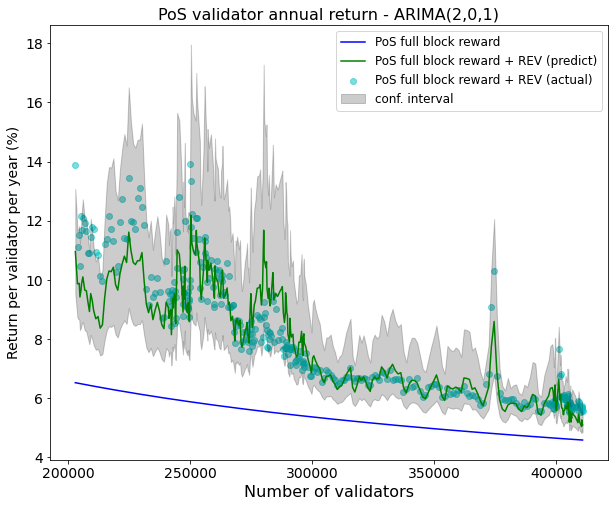

In [53]:
#############################
## 3.2 ARIMA predicted REV ##
#############################
## Import prediction from ARIMA (2,0,1)
rev_predict = pd.read_csv('Data/rev_arima.csv')
rev_predict['datetime_d'] = rev_predict['datetime_h'].apply(lambda x: left(x, 10))

## Merge number of validators to REV prediction
rev_predict = rev_predict.merge(val_num[['datetime_d', 'validator_number']], how='left', on='datetime_d')
rev_predict['annual_full_reward'] = [(4 * annualised_base_reward(n)) for n in rev_predict['validator_number'].tolist()] 
rev_predict['annual_total_reward_with_mev_actual'] = rev_predict['annual_full_reward'] + rev_predict['median_block_net_profit'] * (SECONDS_PER_YEAR / (SECONDS_PER_SLOT * rev_predict['validator_number'])) 
rev_predict['annual_total_reward_with_mev'] = rev_predict['annual_full_reward'] + rev_predict['predict'] * (SECONDS_PER_YEAR / (SECONDS_PER_SLOT * rev_predict['validator_number']))
rev_predict['annual_total_reward_with_mev_lb'] = rev_predict['annual_full_reward'] + rev_predict['predict_lb'] * (SECONDS_PER_YEAR / (SECONDS_PER_SLOT * rev_predict['validator_number'])) 
rev_predict['annual_total_reward_with_mev_ub'] = rev_predict['annual_full_reward'] + rev_predict['predict_ub'] * (SECONDS_PER_YEAR / (SECONDS_PER_SLOT * rev_predict['validator_number'])) 

## Plot total reward by # of validators
agg_rev_data_ar = pd.DataFrame(rev_predict.groupby("validator_number")["annual_full_reward"].median()).reset_index()
reward_actual_ar = pd.DataFrame(rev_predict.groupby("validator_number")["annual_total_reward_with_mev_actual"].median()).reset_index()
reward_pred_ar = pd.DataFrame(rev_predict.groupby("validator_number")["annual_total_reward_with_mev"].median()).reset_index()
reward_pred_ar_lb = pd.DataFrame(rev_predict.groupby("validator_number")["annual_total_reward_with_mev_lb"].median()).reset_index()
reward_pred_ar_ub = pd.DataFrame(rev_predict.groupby("validator_number")["annual_total_reward_with_mev_ub"].median()).reset_index()
mev_ar_lb = pd.DataFrame(rev_predict.groupby("validator_number")["predict_lb"].median()).reset_index()
mev_ar_ub = pd.DataFrame(rev_predict.groupby("validator_number")["predict_ub"].median()).reset_index()
mev_ar_predict = pd.DataFrame(rev_predict.groupby("validator_number")["predict"].median()).reset_index()

agg_rev_data_ar = agg_rev_data_ar.merge(reward_actual_ar, on = "validator_number", how = 'left')
agg_rev_data_ar = agg_rev_data_ar.merge(reward_pred_ar, on = "validator_number", how = 'left')
agg_rev_data_ar = agg_rev_data_ar.merge(reward_pred_ar_lb, on = "validator_number", how = 'left')
agg_rev_data_ar = agg_rev_data_ar.merge(reward_pred_ar_ub, on = "validator_number", how = 'left')
agg_rev_data_ar = agg_rev_data_ar.merge(mev_ar_lb, on = "validator_number", how = 'left')
agg_rev_data_ar = agg_rev_data_ar.merge(mev_ar_ub, on = "validator_number", how = 'left')
agg_rev_data_ar = agg_rev_data_ar.merge(mev_ar_predict, on = "validator_number", how = 'left')

plt.figure(figsize=(10,8))
plt.plot(agg_rev_data_ar['validator_number'], 100*agg_rev_data_ar['annual_full_reward']/32, color = 'b', label='PoS full block reward')
plt.plot(agg_rev_data_ar['validator_number'], 100*agg_rev_data_ar['annual_total_reward_with_mev']/32, color = 'g',label='PoS full block reward + REV (predict)')
plt.scatter(agg_rev_data_ar['validator_number'], 100*agg_rev_data_ar['annual_total_reward_with_mev_actual']/32, color = 'c',label='PoS full block reward + REV (actual)', alpha=0.5)
plt.fill_between(agg_rev_data_ar['validator_number'], 
                  100*agg_rev_data_ar['annual_total_reward_with_mev_lb']/32, 
                  100*agg_rev_data_ar['annual_total_reward_with_mev_ub']/32, 
                  color='k', alpha=0.2, label='conf. interval')
plt.xlabel("Number of validators",fontsize=16)
plt.ylabel("Return per validator per year (%)", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title("PoS validator annual return - ARIMA(2,0,1)", fontsize=16)
plt.legend(prop={'size': 12}, loc='upper right')

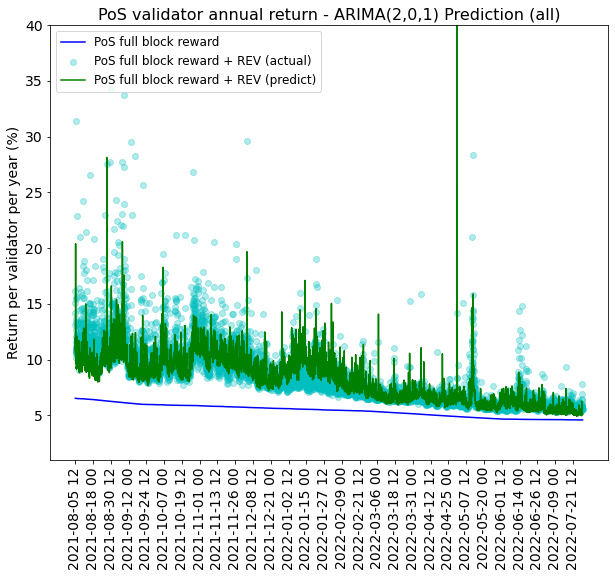

In [54]:
#@title Predicted REV per hourly timestamp
## Plot realised total reward by hour
plt.figure(figsize=(10,8))
plt.plot(rev_predict['datetime_h'], 100*rev_predict['annual_full_reward']/32, color = 'b', label='PoS full block reward')
plt.scatter(rev_predict['datetime_h'], 100*rev_predict['annual_total_reward_with_mev_actual']/32, color = 'c',label='PoS full block reward + REV (actual)', alpha=0.3)
plt.plot(rev_predict['datetime_h'], 100*rev_predict['annual_total_reward_with_mev']/32, color = 'g',label='PoS full block reward + REV (predict)')
# plt.fill_between(rev_predict['datetime_h'], 
#                  100*rev_predict['annual_total_reward_with_mev_lb']/32, 
#                  100*rev_predict['annual_total_reward_with_mev_ub']/32, 
#                  color='k', alpha=0.2, label='prediction conf. interval')
plt.ylabel("Return per validator per year (%)", fontsize=14)
plt.xticks(np.arange(0, len(rev_predict), 300), fontsize=14)
plt.yticks(fontsize=14)
plt.xticks(rotation = 90)
plt.ylim(1, 40)
plt.title("PoS validator annual return - ARIMA(2,0,1) Prediction (all)", fontsize=16)
plt.legend(prop={'size': 12}, loc='upper left')


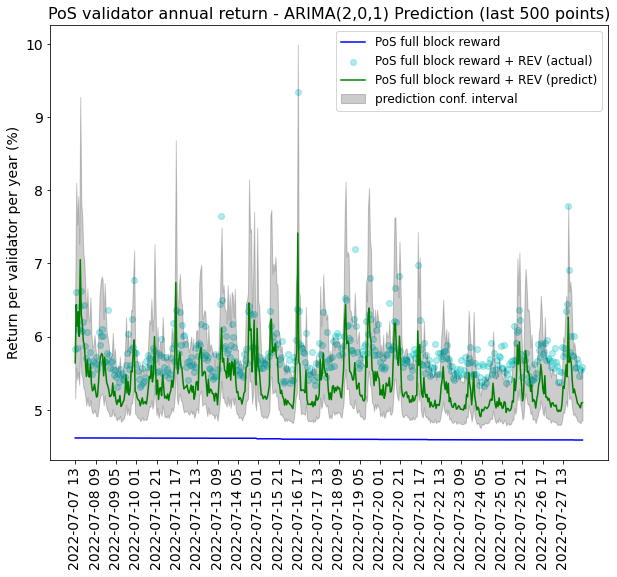

In [55]:
#@title Predicted REV per hourly timestamp - last 500 hours
show_n = 500
plt.figure(figsize=(10,8))
plt.plot(rev_predict['datetime_h'].tail(show_n), 100*rev_predict['annual_full_reward'].tail(show_n)/32, color = 'b', label='PoS full block reward')
plt.scatter(rev_predict['datetime_h'].tail(show_n), 100*rev_predict['annual_total_reward_with_mev_actual'].tail(show_n)/32, color = 'c',label='PoS full block reward + REV (actual)', alpha=0.3)
plt.plot(rev_predict['datetime_h'].tail(show_n), 100*rev_predict['annual_total_reward_with_mev'].tail(show_n)/32, color = 'g',label='PoS full block reward + REV (predict)')
plt.fill_between(rev_predict['datetime_h'].tail(show_n), 
                  100*rev_predict['annual_total_reward_with_mev_lb'].tail(show_n)/32, 
                  100*rev_predict['annual_total_reward_with_mev_ub'].tail(show_n)/32, 
                  color='k', alpha=0.2, label='prediction conf. interval')
plt.ylabel("Return per validator per year (%)", fontsize=14)
plt.xticks(np.arange(0, show_n, 20), fontsize=14)
plt.yticks(fontsize=14)
# plt.ylim(1.45, 1.85)
plt.xticks(rotation = 90)
plt.title("PoS validator annual return - ARIMA(2,0,1) Prediction (last 500 points)", fontsize=16)
plt.legend(prop={'size': 12}, loc='upper right')


Similarly to Random Forest, the following charts combine the proposer scenario (luckiest & unluckiest 1 %) with the ARIMA predicted REV scenario (upper bound 97.5% and lower bound 2.5% of predicted REV).

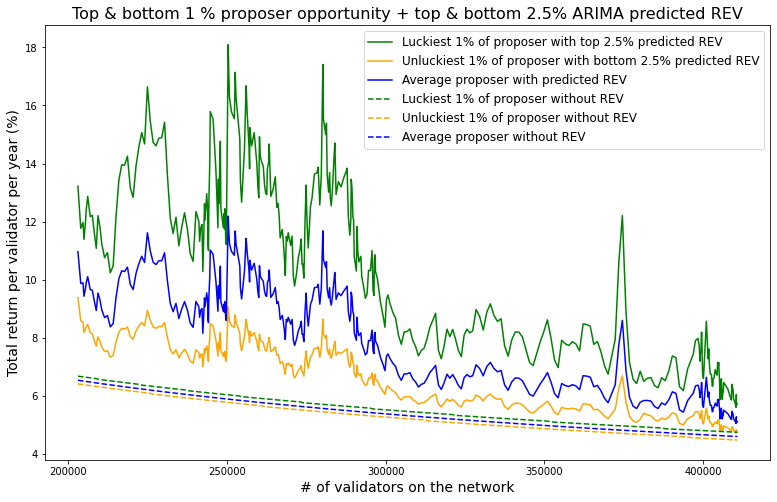

In [56]:

##############################################################
## Incorporate block proposed scenarios into reward return ##
##############################################################
agg_rev_data_ar['attestation_reward'] = 0.75 * agg_rev_data_ar["annual_full_reward"]
agg_rev_data_ar['inclusion_reward'] = 0.25 * agg_rev_data_ar["annual_full_reward"]
agg_rev_data_ar['l_bpo'] = [(binom.ppf(0.01,SECONDS_PER_YEAR/SECONDS_PER_SLOT, 1/n)) for n in agg_rev_data_ar['validator_number'].tolist()]
agg_rev_data_ar['mean_bpo'] = [float(binom.mean(SECONDS_PER_YEAR/SECONDS_PER_SLOT, 1/n)) for n in agg_rev_data_ar['validator_number'].tolist()]
agg_rev_data_ar['u_bpo'] = [(binom.ppf(0.99,SECONDS_PER_YEAR/SECONDS_PER_SLOT, 1/n)) for n in agg_rev_data_ar['validator_number'].tolist()]


l_reward, u_reward = [], [] # With MEV
for i in range(len(agg_rev_data_ar)):
    r_att = agg_rev_data_ar['attestation_reward'][i]
    r_inc = agg_rev_data_ar['inclusion_reward'][i]
    l_reward.append(r_att + r_inc * ((7/8) + (1/8) * agg_rev_data_ar['l_bpo'][i] / agg_rev_data_ar['mean_bpo'][i]))
    l_reward[i] = l_reward[i] + (agg_rev_data_ar['mean_bpo'][i] * agg_rev_data_ar['predict_lb'][i])
    u_reward.append(r_att + r_inc * ((7/8) + (1/8) * agg_rev_data_ar['u_bpo'][i] / agg_rev_data_ar['mean_bpo'][i]))
    u_reward[i] = u_reward[i] + (agg_rev_data_ar['mean_bpo'][i] * agg_rev_data_ar['predict_ub'][i])

l_reward_without_mev, u_reward_without_mev = [], []
for i in range(len(agg_rev_data_ar)):
    r_att = agg_rev_data_ar['attestation_reward'][i]
    r_inc = agg_rev_data_ar['inclusion_reward'][i]
    l_reward_without_mev.append(r_att + r_inc * ((7/8) + (1/8) * agg_rev_data_ar['l_bpo'][i] / agg_rev_data_ar['mean_bpo'][i]))
    u_reward_without_mev.append(r_att + r_inc * ((7/8) + (1/8) * agg_rev_data_ar['u_bpo'][i] / agg_rev_data_ar['mean_bpo'][i]))


fig, ax = plt.subplots(figsize=(13, 8))
ax.plot([n for n in agg_rev_data_ar['validator_number'].tolist()], [100 * r / 32 for r in u_reward] , 'g', label='Luckiest 1% of proposer with top 2.5% predicted REV')
ax.plot([n for n in agg_rev_data_ar['validator_number'].tolist()], [100 * r / 32 for r in l_reward], 'orange', label='Unluckiest 1% of proposer with bottom 2.5% predicted REV')
ax.plot([n for n in agg_rev_data_ar['validator_number'].tolist()], 100*agg_rev_data_ar['annual_total_reward_with_mev']/32, 'b', label='Average proposer with predicted REV')
ax.plot([n for n in agg_rev_data_ar['validator_number'].tolist()], [100 * r / 32 for r in u_reward_without_mev] , 'g', linestyle="dashed", label='Luckiest 1% of proposer without REV')
ax.plot([n for n in agg_rev_data_ar['validator_number'].tolist()], [100 * r / 32 for r in l_reward_without_mev], 'orange', linestyle="dashed",label='Unluckiest 1% of proposer without REV')
ax.plot([n for n in agg_rev_data_ar['validator_number'].tolist()], 100*agg_rev_data_ar['annual_full_reward']/32, 'b', linestyle="dashed", label='Average proposer without REV')
ax.set_xlabel('# of validators on the network', fontsize=14)
ax.set_ylabel('Total return per validator per year (%)', fontsize=14)
ax.set_title('Top & bottom 1 % proposer opportunity + top & bottom 2.5% ARIMA predicted REV', fontsize=16)
# plt.ylim(0, 100)
leg = ax.legend(prop={'size': 12})

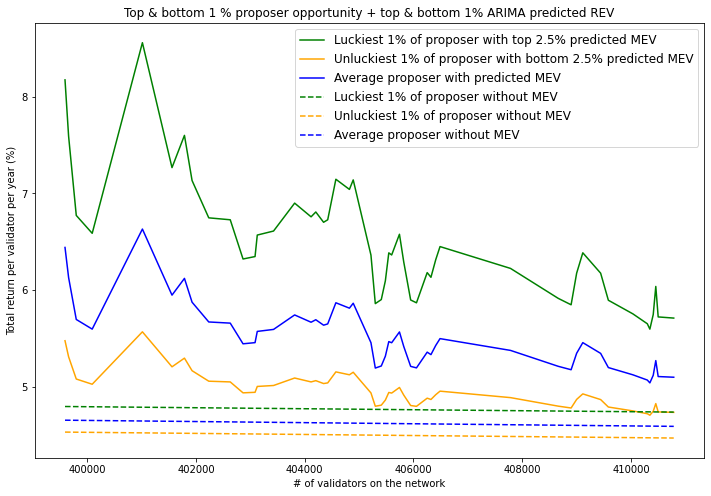

In [57]:
#@title Block proposal opportunties & predicted REV with 2.5%, 97.5% CI - last 50 data points
show_n = 50
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot([n for n in agg_rev_data_ar['validator_number'].tail(show_n).tolist()], [100 * r / 32 for r in u_reward[-show_n:]] , 'g', label='Luckiest 1% of proposer with top 2.5% predicted MEV')
ax.plot([n for n in agg_rev_data_ar['validator_number'].tail(show_n).tolist()], [100 * r / 32 for r in l_reward][-show_n:], 'orange', label='Unluckiest 1% of proposer with bottom 2.5% predicted MEV')
ax.plot([n for n in agg_rev_data_ar['validator_number'].tail(show_n).tolist()], 100*agg_rev_data_ar['annual_total_reward_with_mev'].tail(show_n)/32, 'b', label='Average proposer with predicted MEV')
ax.plot([n for n in agg_rev_data_ar['validator_number'].tail(show_n).tolist()], [100 * r / 32 for r in u_reward_without_mev[-show_n:]] , 'g', linestyle="dashed", label='Luckiest 1% of proposer without MEV')
ax.plot([n for n in agg_rev_data_ar['validator_number'].tail(show_n).tolist()], [100 * r / 32 for r in l_reward_without_mev[-show_n:]], 'orange', linestyle="dashed",label='Unluckiest 1% of proposer without MEV')
ax.plot([n for n in agg_rev_data_ar['validator_number'].tail(show_n).tolist()], 100*agg_rev_data_ar['annual_full_reward'].tail(show_n)/32, 'b', linestyle="dashed", label='Average proposer without MEV')
ax.set_xlabel('# of validators on the network')
ax.set_ylabel('Total return per validator per year (%)')
ax.set_title('Top & bottom 1 % proposer opportunity + top & bottom 1% ARIMA predicted REV')
# plt.ylim(4, 7.5)
leg = ax.legend(prop={'size': 12})



In [58]:
show_list = [207,219,230,241,250,259,267,276,285,294,311,351]
block_proposed = pd.DataFrame({
    '# of val': [agg_rev_data_ar['validator_number'][n] for n in show_list],
    'base reward': [100*(agg_rev_data_ar['annual_full_reward'][n])/32 for n in show_list],
    'return lb': [100*l_reward[n]/32 for n in show_list],
    'med return': [100*(agg_rev_data_ar['annual_total_reward_with_mev'][n])/32 for n in show_list],
    'return ub': [100*u_reward[n]/32 for n in show_list],
})
block_proposed.set_index('# of val')
pd.options.display.float_format = '{:,.2f}'.format
block_proposed

,# of val,base reward,return lb,med return,return ub
0,300250,5.37,6.30,7.36,9.32
1,310309,5.28,5.70,6.29,7.37
2,320208,5.20,5.81,6.60,8.03
3,330711,5.11,5.81,6.68,8.26
4,340813,5.04,5.74,6.61,8.19
5,350938,4.96,5.80,6.79,8.61
6,359938,4.90,5.54,6.33,7.78
7,370055,4.83,5.20,5.75,6.74
8,380178,4.77,5.19,5.77,6.84
9,390302,4.71,5.41,6.13,7.36


([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

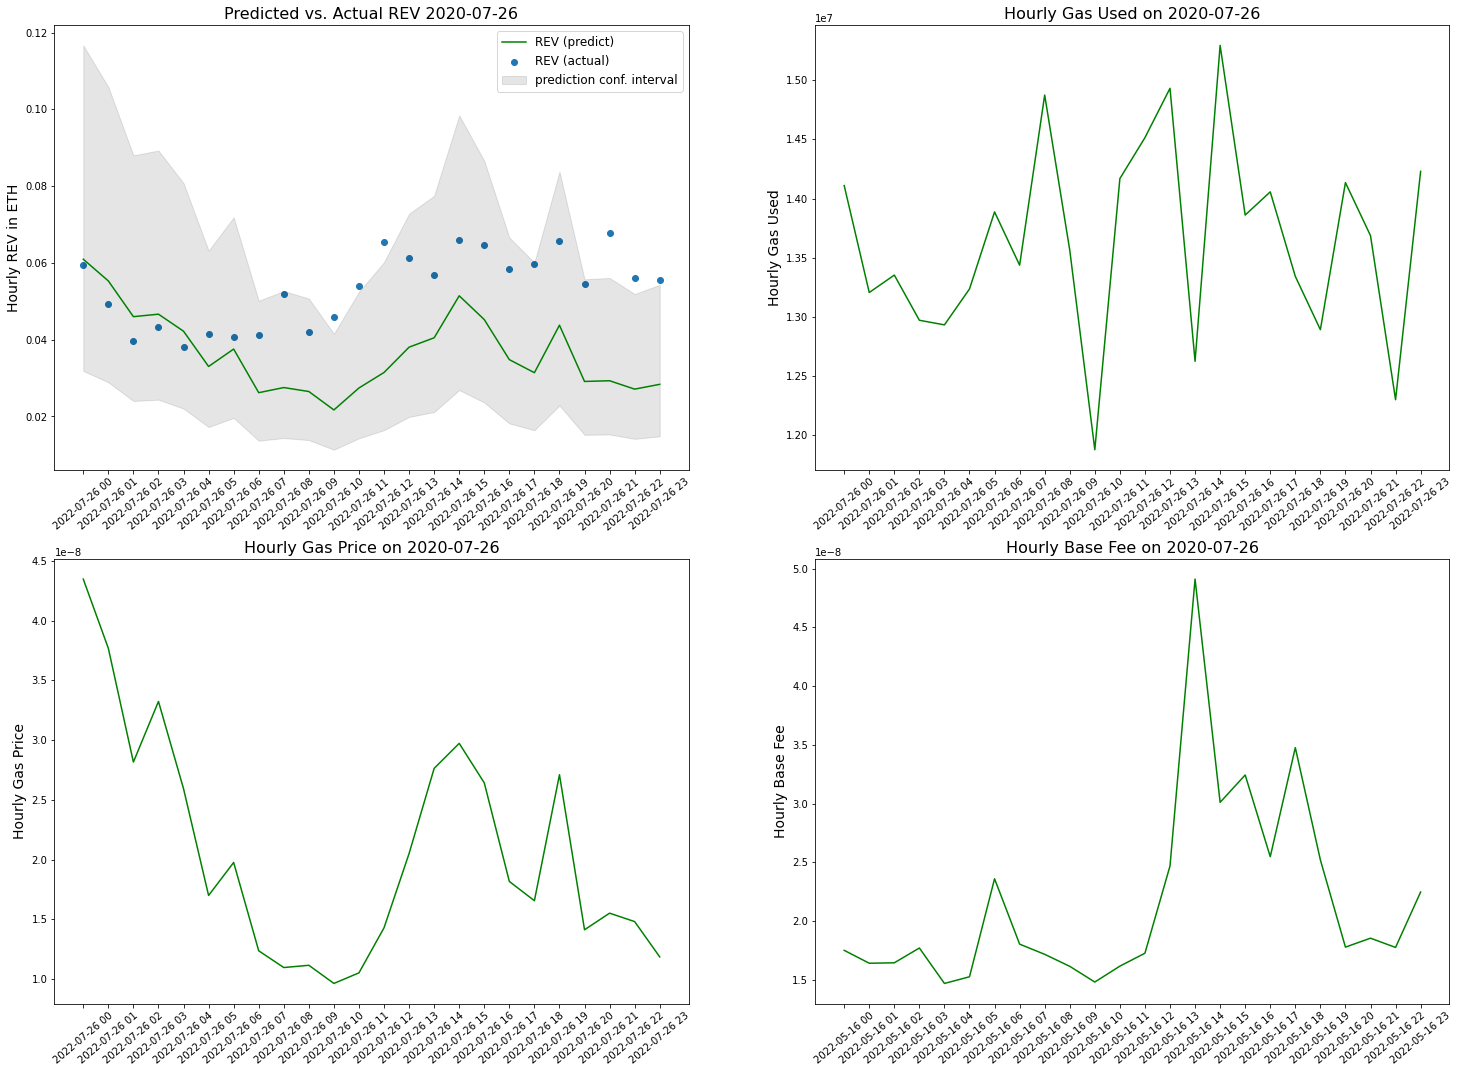

In [59]:
## validator_number = 410499
rev_predict_d1 = rev_predict[(rev_predict['datetime_h']>='2022-07-26 00')&(rev_predict['datetime_h']<'2022-07-27 00')]
rev_predict_d2 = rev_predict[(rev_predict['datetime_h']>='2022-05-16 00')&(rev_predict['datetime_h']<'2022-05-17 00')]

plt.subplots(2, 2, figsize = (25, 18))
## plot prediction 1
plt.subplot(2, 2, 1) 
plt.plot(rev_predict_d1['datetime_h'], rev_predict_d1['predict'], 'g', label='REV (predict)')
plt.scatter(rev_predict_d1['datetime_h'], rev_predict_d1['median_block_net_profit'], label='REV (actual)')
plt.fill_between(rev_predict_d1['datetime_h'], 
                rev_predict_d1['predict_lb'], 
                rev_predict_d1['predict_ub'], 
                color='k', alpha=0.1, label='prediction conf. interval')
plt.ylabel('Hourly REV in ETH', fontsize=14)
plt.title('Predicted vs. Actual REV 2020-07-26', fontsize=16)
plt.xticks(rotation = 40)
plt.legend(prop={'size': 12})

## plot prediction 2
plt.subplot(2, 2, 2)
plt.plot(rev_predict_d1['datetime_h'], rev_predict_d1['median_total_gas_used'], 'g', label='Gas Used')
plt.ylabel('Hourly Gas Used',fontsize=14)
plt.title('Hourly Gas Used on 2020-07-26',fontsize=16)
plt.xticks(rotation = 40)

## plot gas used 1
plt.subplot(2, 2, 3)
plt.plot(rev_predict_d1['datetime_h'], rev_predict_d1['median_tail_gas_price'], 'g', label='Gas Price')
plt.ylabel('Hourly Gas Price',fontsize=14)
plt.title('Hourly Gas Price on 2020-07-26',fontsize=16)
plt.xticks(rotation = 40)


## plot gas used 2
plt.subplot(2, 2, 4)
plt.plot(rev_predict_d2['datetime_h'], rev_predict_d2['median_base_fee_per_gas'], 'g', label='Base Fee')
plt.ylabel('Hourly Base Fee', fontsize=14)
plt.title('Hourly Base Fee on 2020-07-26',fontsize=16)
plt.xticks(rotation = 40)


In [60]:
rev_predict_show = rev_predict[rev_predict['validator_number']==410499]
rev_predict_show = rev_predict_show.rename(columns={'datetime_h': 'datetime'
                                                    ,'median_block_net_profit': 'REV_actual'
                                                    ,'median_tail_gas_price': 'gas_price'
                                                    ,'median_total_gas_used': 'gas_used'
                                                    ,'median_base_fee_per_gas': 'base_fee'
                                                    ,'annual_total_reward_with_mev_actual':'return_actual'
                                                    ,'annual_total_reward_with_mev':'predict(eth)'
                                                    ,'annual_total_reward_with_mev_lb':'lb(eth)'
                                                    ,'annual_total_reward_with_mev_ub':'ub(eth)' 
                                                    ,'validator_number': 'validator_n'
                                                   })
rev_predict_show['gas_price'] = rev_predict_show['gas_price']*1e18
rev_predict_show['base_fee'] = rev_predict_show['base_fee']*1e18
rev_predict_show['predict_%'] = rev_predict_show['predict(eth)']*100/32
rev_predict_show['lb_%'] = rev_predict_show['lb(eth)']*100/32
rev_predict_show['ub_%'] = rev_predict_show['ub(eth)']*100/32
rev_predict_show = rev_predict_show[['validator_n','datetime','gas_price','gas_used','base_fee','predict_%','lb_%','ub_%']]
rev_predict_show

,validator_n,datetime,gas_price,gas_used,base_fee,predict_%,lb_%,ub_%
8532,410499,2022-07-27 00,"10,640,235,031.00","13,743,025.50","9,730,257,512.00",5.10,4.86,5.57
8533,410499,2022-07-27 01,"7,622,029,693.00","14,424,297.00","6,742,063,479.00",5.04,4.82,5.44
8534,410499,2022-07-27 02,"10,553,120,790.00","14,713,262.00","9,854,601,595.00",5.09,4.85,5.56
8535,410499,2022-07-27 03,"9,930,572,680.00","14,381,705.50","9,048,692,034.00",5.10,4.85,5.56
8536,410499,2022-07-27 04,"8,476,948,046.00","13,886,473.00","7,541,306,332.00",5.06,4.83,5.48
8537,410499,2022-07-27 05,"9,059,370,129.00","13,756,220.00","8,231,843,310.00",5.05,4.83,5.47
8538,410499,2022-07-27 06,"8,514,153,927.50","14,395,792.50","7,596,159,356.50",5.06,4.84,5.50
8539,410499,2022-07-27 07,"7,089,700,411.00","13,859,618.00","6,301,152,917.00",5.00,4.80,5.37
8540,410499,2022-07-27 08,"6,533,117,167.00","14,425,841.00","5,830,414,562.00",4.98,4.79,5.33
8541,410499,2022-07-27 09,"6,550,361,561.00","14,931,139.00","5,776,759,411.00",5.00,4.80,5.37


In [36]:
rev_predict.head(5)

,Unnamed: 0,datetime_h,median_block_net_profit,median_tail_gas_price,median_total_gas_used,median_base_fee_per_gas,predict,predict_lb,predict_ub,is_in_ci,datetime_d,validator_number,annual_full_reward,annual_total_reward_with_mev_actual,annual_total_reward_with_mev,annual_total_reward_with_mev_lb,annual_total_reward_with_mev_ub
0,0,2021-08-05 12,0.24,0.00,"21,759,183.00",0.00,0.10,0.07,0.14,False,2021-08-05,203030,2.09,5.16,3.40,3.01,3.95
1,1,2021-08-05 13,0.16,0.00,"13,933,130.00",0.00,0.11,0.08,0.16,True,2021-08-05,203030,2.09,4.19,3.53,3.07,4.21
2,2,2021-08-05 14,0.21,0.00,"12,333,539.00",0.00,0.14,0.09,0.20,False,2021-08-05,203030,2.09,4.83,3.84,3.27,4.68
3,3,2021-08-05 15,0.19,0.00,"12,023,403.50",0.00,0.11,0.07,0.16,False,2021-08-05,203030,2.09,4.52,3.48,3.03,4.16
4,4,2021-08-05 16,0.22,0.00,"12,026,875.00",0.00,0.11,0.07,0.17,False,2021-08-05,203030,2.09,5.00,3.53,3.06,4.24
